## Table of Contents
- [Part 1: Hearthstone Cards Collection EDA](#hearthstone-eda)
    - [Download Data](#download-data)
    - [Exploratory Data Analysis](#data-eda)
    - [Data Visualization (All Cards)](#data-visualization-all-cards)
    - [Data Visualization (Per Expansion Basis)](#data-visualization-per-expansion)
- [Part 2: Q-Learning for FrozenLake-v0, OpenAI Gym environment](#frozen-lake)
    - [Q-Learning Approach](#q-learn)
        - [OpenAI Gym Stochastic FrozenLake approach](#stochastic-field)
        - [Personal Deterministic FrozenLake approach](#deterministic-field)
        - [Play Against Environment](#pve)
    - [DNN Approach](#dnn)

## Part 1: Hearthstone Cards Collection EDA <a class="anchor" id="hearthstone-eda"></a>

The purpose is to examine existing Heartstone cards from Basic set and up to latest expansion - "Rise of Shadows".

Dataset was downloaded from: <a href="https://hearthstoneapi.com/">HearthstoneAPI.com</a>

This dataset contains only cards. It doesn't have values about win-rates or cards usage, so we can't perform following:
- Predicting the deck archetype based on the cards features in the deck.
- Seek relationships between the cost of the deck and it's popularity.
- Describe the evolution of the meta-game over-time.
- Find out unbalanced (overplayed) cards

What we can do, is:
- Examine available card distributions
    - Total
    - Per expansion
- Locate and examine outlier cards
- Prepare new dataset for further usage

All this data analysis is useful for Game Designers.

### Step 1: Download data <a class="anchor" id="download-data"></a>

First we import bunch of libraries we will use:

In [1]:
import requests
import json
import csv

import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter

import unicodedata
import matplotlib.pyplot as plot
%matplotlib inline

In [2]:
# Global constants

cards_dataset_file = 'Hearthstone.csv'
personal_api_key = '6e71966f07msh8a143cc8aa41b0ap163193jsnbb191d6020af'
endpoint_url = 'https://omgvamp-hearthstone-v1.p.rapidapi.com/cards'

Now, let us define few functions that we need for initial dataset load:
- **loadDataset_Hearthstone()** : first will try to load from local CSV file, and if it fails, call to web-server will be made and response will be saved to local file. Returns: **Pandas** dataframe.
- **fixDictEncoding(dictionary)** : Some voodoo magic on unicode strings
- **downloadDataset_Hearthstone()** : will use my personal secret API key to grab latest cards from endpoint
- **saveResponseBodyToCSV(responseBody)** : Makes initial cleaning and saves all info to CSV file

In [3]:
def fixDictEncoding(dictionary):
    for key, value in dictionary.items():
        # Cars have flavour text with different unicode symbols. Let's normilize them before saving file
        if isinstance(value, str):
            dictionary[key] = unicodedata.normalize('NFKD', dictionary[key]).encode('ascii','ignore')
            dictionary[key] = dictionary[key].decode('UTF-8')
    return dictionary


def saveResponseBodyToCSV (responseBody):
    with open(cards_dataset_file, 'w', newline='') as f_writer:
        # List of keys can be found here: https://rapidapi.com/omgvamp/api/hearthstone if tested with personal API key
        keys = ['cardId', 'name', 'cardSet', 'type', 'rarity', 'mechanics_list', 'mechanics_count', 'playerClass', 'faction', 'cost',
                'health', 'attack', 'collectible', 'race', 'artist', 'text', 'flavor', 'locale']

        w = csv.DictWriter(f_writer, fieldnames=keys, extrasaction='ignore')
        w.writeheader()

        counters = Counter()
        for group, group_cards in responseBody.items():
            for card in group_cards:
                try:
                    if 'mechanics' in card:
                        card['mechanics_count'] = len(card['mechanics'])                    

                        mechanics = []
                        for item in card['mechanics']:
                            # Trim bold tags from text
                            item['name'] = item['name'].replace('<b>','').replace('</b>','')
                            mechanics.append(item['name'])

                        card['mechanics_list'] = '#'.join(mechanics)
                    else:
                        card['mechanics_count'] = 0
                        card['mechanics_list'] = "None"
                    
                    card = fixDictEncoding(card) 
                    
                    w.writerow(card)
                    counters[group] += 1

                except UnicodeEncodeError as ex:
                    print ('---> Unicode issues with following card:')
                    print (card)
                    counters['UnicodeEncodeError'] += 1
                    
    print ('---> Local CSV file saved.')
    print (counters.most_common)

def downloadDataset_Hearthstone ():   
    request_headers = {'X-Mashape-Key': personal_api_key}
    response = requests.get(endpoint_url, headers=request_headers)
    
    return response

def loadDataset_Hearthstone ():
    try:
        all_cards_df = pd.read_csv(cards_dataset_file)
    except Exception as e:
            print ('--->Error in reading:', cards_dataset_file)
            print (e)
            print ('---> Fetching dataset.')
            
            response = downloadDataset_Hearthstone()
            if (response.status_code == 200):
                print ("---> Data downloaded.")
                rawData = response.json()
                saveResponseBodyToCSV(rawData)
                    
                all_cards_df = pd.read_csv(cards_dataset_file)
            else:
                print ("---> Check API key and URL once more.")
    
    print ('---> We already have local csv file copy. Reading.')
    return all_cards_df

In [4]:
# Now actually get Pandas dataframe with ALL Hearthstone cards
all_cards = loadDataset_Hearthstone()

---> We already have local csv file copy. Reading.


### Step 2: Exploratory Data Analysis <a class="anchor" id="data-eda"></a>

In [5]:
# Print dataframe head
all_cards.head()

,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
0,GAME_004,AFK,Basic,Enchantment,NaN,None,0,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Your turns are shorter.,NaN,enUS
1,CS2_041e,Ancestral Infusion,Basic,Enchantment,NaN,Taunt,1,Shaman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Taunt.,NaN,enUS
2,HERO_09,Anduin Wrynn,Basic,Hero,Free,None,0,Priest,Neutral,NaN,30.0,NaN,True,NaN,NaN,NaN,NaN,enUS
3,EX1_399e,Berserking,Basic,Enchantment,NaN,None,0,Neutral,NaN,NaN,NaN,NaN,NaN,NaN,NaN,This minion has increased Attack.,NaN,enUS
4,CS2_092e,Blessing of Kings,Basic,Enchantment,NaN,None,0,Paladin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,+4/+4.,NaN,enUS


Ok, so there are a bunch of columns we don't need. Let's get rid of 'em.

In [6]:
altered_dataframe = all_cards.drop(columns=['cardId', 'faction', 'collectible', 'artist', 'text', 'flavor', 'locale'])
altered_dataframe.head()

,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,cost,health,attack,race
0,AFK,Basic,Enchantment,NaN,None,0,Neutral,NaN,NaN,NaN,NaN
1,Ancestral Infusion,Basic,Enchantment,NaN,Taunt,1,Shaman,NaN,NaN,NaN,NaN
2,Anduin Wrynn,Basic,Hero,Free,None,0,Priest,NaN,30.0,NaN,NaN
3,Berserking,Basic,Enchantment,NaN,None,0,Neutral,NaN,NaN,NaN,NaN
4,Blessing of Kings,Basic,Enchantment,NaN,None,0,Paladin,NaN,NaN,NaN,NaN


Now let's look at data we don't have:

In [7]:
altered_dataframe.isnull().sum()

name                  0
cardSet               0
type                  0
rarity             4242
mechanics_list        0
mechanics_count       0
playerClass          13
cost               1698
health             3664
attack             4053
race               5895
dtype: int64

This is a lot of empty values. Let's reduce the numbers using some data engineering:

In [8]:
# List all unique card sets
altered_dataframe.cardSet.unique()

array(['Basic', 'Classic', 'Hall of Fame', 'Naxxramas',
       'Goblins vs Gnomes', 'Blackrock Mountain', 'The Grand Tournament',
       'The League of Explorers', 'Whispers of the Old Gods',
       'One Night in Karazhan', 'Mean Streets of Gadgetzan',
       "Journey to Un'Goro", 'Knights of the Frozen Throne',
       'Kobolds & Catacombs', 'The Witchwood', 'The Boomsday Project',
       "Rastakhan's Rumble", 'Rise of Shadows', 'Tavern Brawl',
       'Taverns of Time', 'Hero Skins', 'Missions', 'Credits'],
      dtype=object)

In [9]:
# Remove all card sets that are not the extensions
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Hall of Fame']
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Tavern Brawl']
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Taverns of Time']
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Hero Skins']
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Missions']
altered_dataframe = altered_dataframe[altered_dataframe.cardSet != 'Credits']

In [10]:
altered_dataframe.cardSet.unique()

array(['Basic', 'Classic', 'Naxxramas', 'Goblins vs Gnomes',
       'Blackrock Mountain', 'The Grand Tournament',
       'The League of Explorers', 'Whispers of the Old Gods',
       'One Night in Karazhan', 'Mean Streets of Gadgetzan',
       "Journey to Un'Goro", 'Knights of the Frozen Throne',
       'Kobolds & Catacombs', 'The Witchwood', 'The Boomsday Project',
       "Rastakhan's Rumble", 'Rise of Shadows'], dtype=object)

In [11]:
altered_dataframe.isnull().sum()

name                  0
cardSet               0
type                  0
rarity             3438
mechanics_list        0
mechanics_count       0
playerClass           6
cost               1387
health             3036
attack             3352
race               4872
dtype: int64

In [12]:
altered_dataframe.type.unique()

array(['Enchantment', 'Hero', 'Minion', 'Spell', 'Weapon', 'Hero Power'],
      dtype=object)

In [13]:
# Heroes are not part of expansions as well as their abilities. Enchantment are basically effect configs. So we might as well skip these.
altered_dataframe = altered_dataframe[altered_dataframe.type != 'Hero Power']
altered_dataframe = altered_dataframe[altered_dataframe.type != 'Hero']
altered_dataframe = altered_dataframe[altered_dataframe.type != 'Enchantment']

In [14]:
# So, some cards don't have health or attack or even cost. Let's set them to 0
altered_dataframe['cost'].fillna(0, inplace=True)
altered_dataframe['health'].fillna(0, inplace=True)
altered_dataframe['attack'].fillna(0, inplace=True)

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


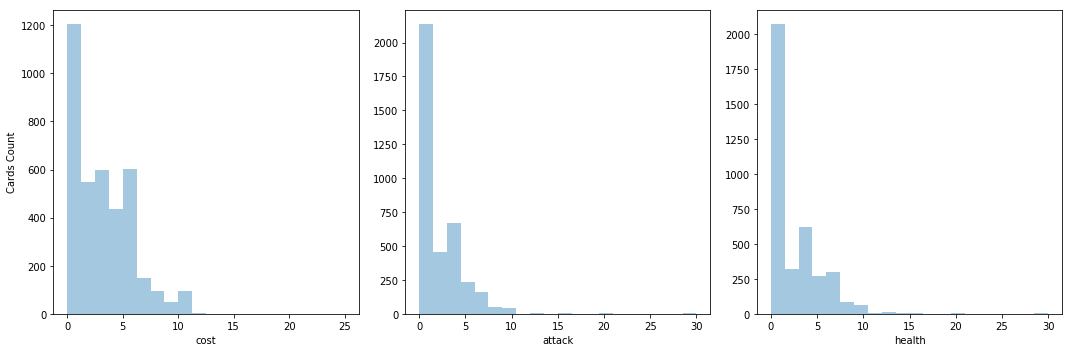

In [15]:
fig, axs = plot.subplots(figsize=(15,5), ncols=3, nrows=1)
sns.distplot(altered_dataframe['cost'], kde=False, bins=20, ax=axs[0])
sns.distplot(altered_dataframe['attack'], kde=False, bins=20, ax=axs[1])
sns.distplot(altered_dataframe['health'], kde=False, bins=20, ax=axs[2])

axs[0].set_ylabel('Cards Count')

plot.tight_layout()
plot.show()

From above plot we can see that most of the cards are low on stats. the higher the cost, less cards are introduced. And only few cards with Mana cost above 10 are present. 
All cards that cost >10 Mana, facilitate specific mechanics and counters to reduce their cost below 10.

In [16]:
# Now, let us check card distribution per class
altered_dataframe.playerClass.value_counts()

Neutral         1733
Druid            307
Warlock          223
Mage             222
Warrior          220
Hunter           219
Paladin          212
Shaman           211
Rogue            210
Priest           198
Death Knight      21
Dream              5
Name: playerClass, dtype: int64

In [17]:
# Death Knight and Dream are not Playable classes. We will change them to Neutral.
altered_dataframe.playerClass.replace('Dream', 'Neutral', inplace = True)
altered_dataframe.playerClass.replace('Death Knight', 'Neutral', inplace = True)

In [18]:
altered_dataframe.playerClass.value_counts()

Neutral    1759
Druid       307
Warlock     223
Mage        222
Warrior     220
Hunter      219
Paladin     212
Shaman      211
Rogue       210
Priest      198
Name: playerClass, dtype: int64

In [19]:
altered_dataframe.rarity.unique()

array(['Common', 'Free', nan, 'Epic', 'Rare', 'Legendary'], dtype=object)

In [20]:
#We shall replace NoNs with empty string for rarity field 
altered_dataframe.rarity.fillna('', inplace=True)
altered_dataframe.head()

,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,cost,health,attack,race
31,Frog,Basic,Minion,Common,Taunt,1,Neutral,0.0,1.0,0.0,Beast
61,Ancestral Healing,Basic,Spell,Free,Taunt,1,Shaman,0.0,0.0,0.0,NaN
62,Avatar of the Coin,Basic,Minion,Free,None,0,Neutral,0.0,1.0,1.0,NaN
63,Backstab,Basic,Spell,Free,None,0,Rogue,0.0,0.0,0.0,NaN
64,Bottled Madness,Basic,Spell,Free,None,0,Warlock,0.0,0.0,0.0,NaN


In [21]:
# Same for Race
altered_dataframe.race.fillna('', inplace=True)
altered_dataframe.head()

,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,cost,health,attack,race
31,Frog,Basic,Minion,Common,Taunt,1,Neutral,0.0,1.0,0.0,Beast
61,Ancestral Healing,Basic,Spell,Free,Taunt,1,Shaman,0.0,0.0,0.0,
62,Avatar of the Coin,Basic,Minion,Free,None,0,Neutral,0.0,1.0,1.0,
63,Backstab,Basic,Spell,Free,None,0,Rogue,0.0,0.0,0.0,
64,Bottled Madness,Basic,Spell,Free,None,0,Warlock,0.0,0.0,0.0,


In [22]:
altered_dataframe.isnull().sum()

name               0
cardSet            0
type               0
rarity             0
mechanics_list     0
mechanics_count    0
playerClass        0
cost               0
health             0
attack             0
race               0
dtype: int64

OK. So now we have more or less cleaned data, we can work further with.

In [23]:
# We will use this to parse mechanics per card (remember delimeter we used earlier -> #), and create set of all available mechanics
def parseUniqueMechanics(dataframe):
    _mechanics = set()

    for uniqueMechanic in dataframe.mechanics_list.unique():
        if len(uniqueMechanic) > 1:
            for mechanic in uniqueMechanic.split('#'):
                if mechanic not in _mechanics:
                    _mechanics.add(mechanic)

    print ('---> Mechanics Found: [%s]' % ','.join(_mechanics))
    return _mechanics

In [24]:
uniqueMechanicsList = parseUniqueMechanics(altered_dataframe)

---> Mechanics Found: [Discover,Taunt,AdjacentBuff,Lifesteal,Overload,Poisonous,Charge,None,Rush,ImmuneToSpellpower,Freeze,Silence,AIMustPlay,Windfury,Quest,Deathrattle,Echo,Adapt,Twinspell,Spell Damage,Battlecry,Divine Shield,Jade Golem,Secret,Casts When Drawn,Recruit,Stealth,Overkill,Inspire,AffectedBySpellPower,Combo,Aura,Magnetic,InvisibleDeathrattle]


In [25]:
# Now, we don't have much to do with such values as strings. Let's convert 'em to appropriate columns.
def convertMechanicsIntoFeatures(mechanics, dataframe):
    for mechanic in mechanics:
        for index, row in dataframe.iterrows():
            mechanics_str = row[4]
        
            if mechanic in mechanics_str:
                dataframe.set_value(index, mechanic, 1)
            else:
                dataframe.set_value(index, mechanic, 0)

In [26]:
convertMechanicsIntoFeatures(uniqueMechanicsList, altered_dataframe)

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [27]:
# Droping 'mechanics_list' column, now that we have a set of boolean ones to work with
altered_dataframe = altered_dataframe.drop(columns=['mechanics_list'])

In [28]:
# And save our new dataframe in CSV, so we could access it without all the preparations.
altered_dataframe.to_csv('hearthstone_dataframe_parsed.csv')

### Step 3: Data Visualization (All Cards) <a class="anchor" id="data-visualization-all-cards"></a>

(-1.4400791541571683,
 1.2214221653074862,
 -1.212428359861557,
 1.2087011119068967)

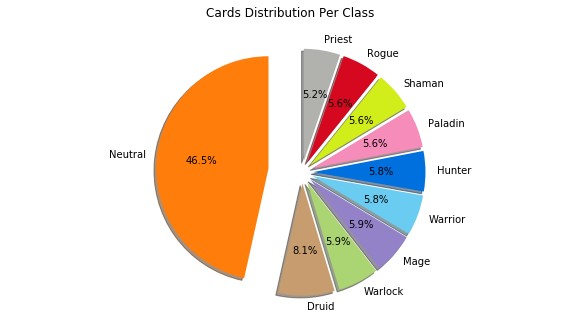

In [29]:
classes_palette = {'Neutral': '#FF7D0A', 
                   'Druid': '#C79C6E', 
                   'Warrior': '#ABD473', 
                   'Hunter': '#9482C9', 
                   'Warlock': '#69CCF0', 
                   'Mage': '#0070DE',
                   'Shaman': '#F58CBA',
                   'Paladin': '#D1ED1A',
                   'Rogue': '#D60820',
                   'Priest': '#B1B2AD'}

classes_label = ['Neutral', 'Druid', 'Warrior', 'Hunter', 'Warlock', 'Mage', 'Shaman', 'Paladin', 'Rogue', 'Priest']
class_colors = ['#FF7D0A', '#C79C6E', '#ABD473', '#9482C9', '#69CCF0', '#0070DE', '#F58CBA', '#D1ED1A', '#D60820', '#B1B2AD']

cards_per_class = altered_dataframe.playerClass.value_counts()
classes = cards_per_class.keys()
cards_count = cards_per_class.values
explode = (0.3, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1)

fig, axes = plot.subplots(nrows=1, ncols=1, figsize=(10,5))
axes.set_title('Cards Distribution Per Class', y=1.05)
axes.pie(cards_count, labels=classes, colors=class_colors, explode=explode, autopct='%1.1f%%', shadow=True, startangle=90)
axes.axis('equal')

From above distribution we can see, that **Priest** class has less amount of specific cards than other classes. On a countrary **Druid** has highest amount of class specific cards in play. 

**Conclusion**: all player classes rely on Neutral cards, but not all classes are in equilibrium in terms of class specific card availability. We **might** expect to have some boost in Priest cards in following expansions.

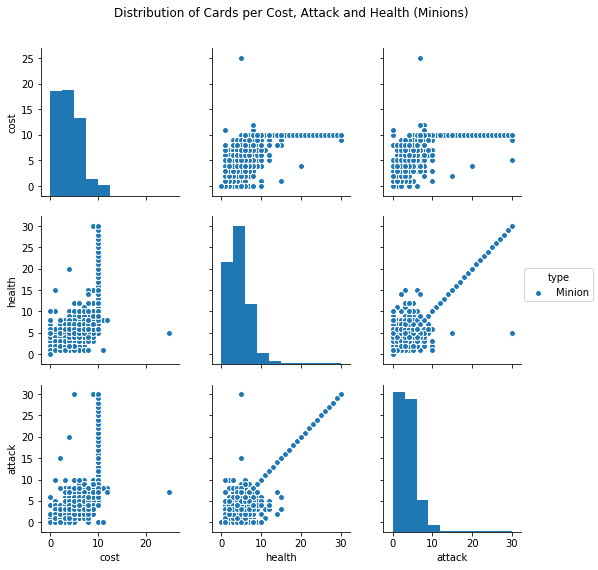

In [30]:
minions_dataframe = altered_dataframe[altered_dataframe.type == 'Minion'][['cost', 'health', 'attack', 'type']]
sns.pairplot(minions_dataframe, hue='type', kind='scatter')
plot.suptitle('Distribution of Cards per Cost, Attack and Health (Minions)', y=1.05)
plot.show()

So, as we can see, mostly all cards are balanced enough. Except few anomalies.
The long straight line is very specific card set, and one meta in particular - **<a href="https://hearthstone.gamepedia.com/Jade_Rogue">Jade Rogue</a>**. I know this by fact. But let us check it once more.

In [31]:
jade_golems = altered_dataframe[altered_dataframe.type == 'Minion'][altered_dataframe.name == 'Jade Golem']
jade_golems.head(5).append(jade_golems.tail(5))

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,name,cardSet,type,rarity,mechanics_count,playerClass,cost,health,attack,race,...,Casts When Drawn,Recruit,Stealth,Overkill,Inspire,AffectedBySpellPower,Combo,Aura,Magnetic,InvisibleDeathrattle
2198,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,1.0,1.0,1.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2235,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,2.0,2.0,2.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2254,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,3.0,3.0,3.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2282,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,4.0,4.0,4.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2312,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,5.0,5.0,5.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2386,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,10.0,26.0,26.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2387,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,10.0,27.0,27.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2388,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,10.0,28.0,28.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2389,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,10.0,29.0,29.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2390,Jade Golem,Mean Streets of Gadgetzan,Minion,,1,Neutral,10.0,30.0,30.0,,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Also, we do have some other cards that doesn't seem to fit. Let's check what they are:

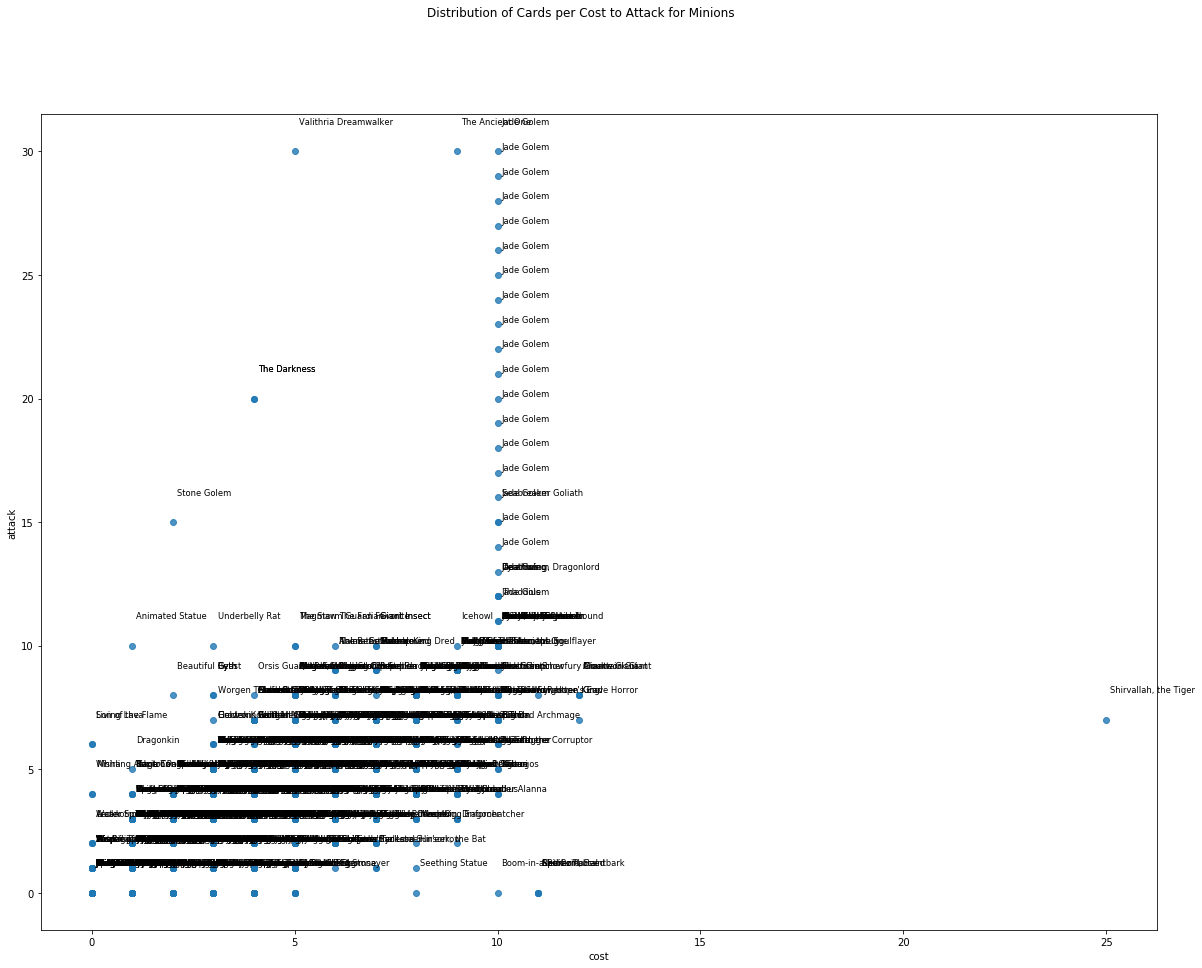

In [32]:
minions_dataframe = altered_dataframe[altered_dataframe.type == 'Minion'][['cost', 'health', 'attack', 'type', 'name']]

cost = minions_dataframe.cost.tolist()
attack = minions_dataframe.attack.tolist()
name = minions_dataframe.name.tolist()

fig, ax = plot.subplots()
fig.set_size_inches(20,15)
#sns.regplot(data=minions_dataframe, x='cost', y='attack')
p1 = sns.regplot(data=minions_dataframe, x='cost', y='attack',fit_reg=False)

for line in range(0, minions_dataframe.shape[0]):
    p1.text(cost[line]+0.1, 
            attack[line]+1.1, 
            name[line],
            horizontalalignment='left',size='small',color='black')
        
plot.suptitle('Distribution of Cards per Cost to Attack for Minions')
plot.show()

It's almost impossible to see card titles when they are in good cohesion, but there are few that stand out (except Jade Golems, we looked at before). So these cards are:
- Shirvallah, the Tiger
- Stone Golem
- The Darkness
- Valithria Dreamwalker
- The Ancient One

These are 5 anomaly cards that are in play.

In [33]:
# Analyze anomaly cards
aCards = ['Shirvallah, the Tiger', 'Stone Golem', 'The Darkness', 'Valithria Dreamwalker', 'The Ancient One']

for card in aCards:
    tCard = all_cards[all_cards.name == card]
    display(tCard)
    print (card, '-->', tCard.text.values)

,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
4850,TRL_300,"Shirvallah, the Tiger",Rastakhan's Rumble,Minion,Legendary,Divine Shield#Rush#Lifesteal,3,Paladin,NaN,25.0,5.0,7.0,True,Beast,Arthur Gimaldinov,"[x]<b>Divine Shield</b>, <b>Rush</b>, <b>Lifes...",On bended knee Thekal placed his weapon upon S...,enUS


Shirvallah, the Tiger --> ["[x]<b>Divine Shield</b>, <b>Rush</b>, <b>Lifesteal</b>\\n Costs (1) less for each Mana\\nyou've spent on spells."]


,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
3274,LOOTA_BOSS_20t,Stone Golem,Kobolds & Catacombs,Minion,NaN,Deathrattle,1,Neutral,Neutral,2.0,5.0,15.0,NaN,NaN,Yang Dai,Can't attack.\n<b>Deathrattle:</b> Lose a Mana...,NaN,enUS


Stone Golem --> ["Can't attack.\\n<b>Deathrattle:</b> Lose a Mana_Crystal."]


,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
1549,LOEA04_30,The Darkness,The League of Explorers,Spell,NaN,None,0,Neutral,NaN,0.0,NaN,NaN,NaN,NaN,NaN,<b>Take the Shortcut?</b>,NaN,enUS
3015,LOOTA_BOSS_49h,The Darkness,Kobolds & Catacombs,Hero,NaN,None,0,Priest,NaN,NaN,70.0,NaN,NaN,NaN,L. Lullabi & K. Turovec,<i>There's a reason to always keep a light on ...,NaN,enUS
3373,LOOT_526d,The Darkness,Kobolds & Catacombs,Minion,Legendary,None,0,Neutral,NaN,4.0,20.0,20.0,NaN,NaN,L. Lullabi & K. Turovec,@,NaN,enUS
3374,LOOT_526,The Darkness,Kobolds & Catacombs,Minion,Legendary,Battlecry,1,Neutral,NaN,4.0,20.0,20.0,True,NaN,L. Lullabi & K. Turovec,[x]Starts dormant.\n<b>Battlecry:</b> Shuffle ...,I would rather light a single candle than curs...,enUS


The Darkness --> ['<b>Take the Shortcut?</b>'
 "<i>There's a reason to always keep a light on down here.</i>" '@'
 '[x]Starts dormant.\\n<b>Battlecry:</b> Shuffle 3 Candles\\ninto the enemy deck. When\\ndrawn, this awakens.']


,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
2877,ICCA10_001,Valithria Dreamwalker,Knights of the Frozen Throne,Minion,NaN,None,0,Neutral,NaN,5.0,5.0,30.0,NaN,Dragon,NaN,Can't attack or be attacked while damaged.,NaN,enUS


Valithria Dreamwalker --> ["Can't attack or be attacked while damaged."]


,cardId,name,cardSet,type,rarity,mechanics_list,mechanics_count,playerClass,faction,cost,health,attack,collectible,race,artist,text,flavor,locale
1908,OG_173a,The Ancient One,Whispers of the Old Gods,Minion,NaN,None,0,Neutral,NaN,9.0,30.0,30.0,NaN,NaN,Wei Wang,NaN,NaN,enUS


The Ancient One --> [nan]


- **Shirvallah, the Tiger** - Legendary (7,5) Minion Has 3 additional mechanics, but can't be used early in game due to high cost.
- **Stone Golem** - 2 mana (15, 5) Neutral Minion. Can be played by any hero early in the game. Is useless if not used in combination with cards that grant Silence or Taunt. But allows for some high risk strategies in early play.
- **The Darkness** - 4 Mana (20, 20) Neutral Legendary Minion. Can't be used until enemy will draw 3 Candles that are shuffled into his deck upon summon. Dormant cards can't be targeted but they do use space on a field. Suitable for long control decks. Low cost and high effect are more or less balanced.
- **Valithria Dreamwalker** - 4 Mana (30, 5) Legendary Minion. Can be efficiently used only in conduction with healing cards or abilities, otherwise is very easy to be controlled or destroyed by opponent.
- **The Ancient One** - This card can't be added to your deck. Seconds after 30 Mana (30, 30) Jade Golem card due to low cost. Player needs to play two **The Blood of the Ancient One** in one turn two cast this card. so basically cost vary from 9 (30,30) to 18 (30,30). Which is fine.

From this we can see that these few outliers we have are not overpowered and require player to take high-risk - high-rewards strategies.

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


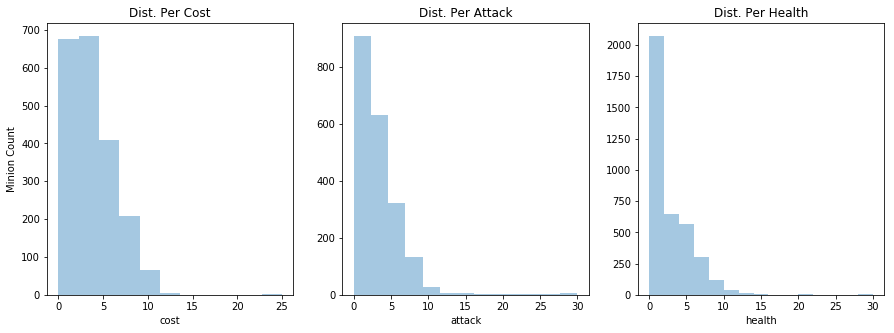

In [34]:
fig, axs = plot.subplots(figsize=(15,5), ncols=3, nrows=1)

sns.distplot(minions_dataframe['cost'], kde=False, bins=11, ax=axs[0])
sns.distplot(minions_dataframe['attack'], kde=False, bins=13, ax=axs[1])
sns.distplot(altered_dataframe['health'], kde=False, bins=15, ax=axs[2])

axs[0].set_ylabel('Minion Count')

axs[0].set_title('Dist. Per Cost')
axs[1].set_title('Dist. Per Attack')
axs[2].set_title('Dist. Per Health')
plot.show()

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


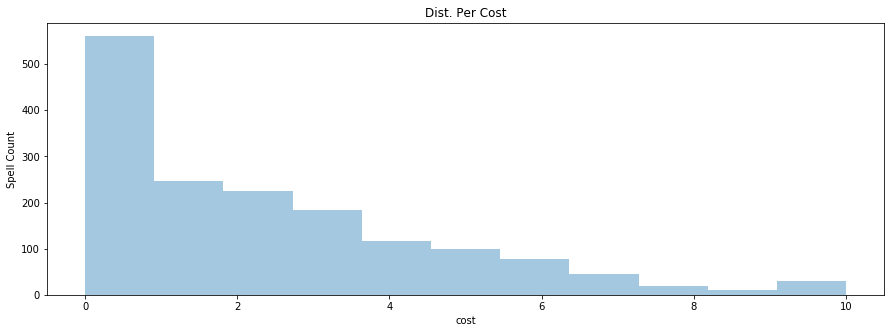

In [35]:
spells_dataframe = altered_dataframe[altered_dataframe.type == 'Spell'][['cost']]

fig, axs = plot.subplots(figsize=(15,5), ncols=1, nrows=1)
sns.distplot(spells_dataframe['cost'], kde=False, bins=11, ax=axs)

axs.set_ylabel('Spell Count')
axs.set_title('Dist. Per Cost')

plot.show()

C:\Users\vieliashevskyi\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


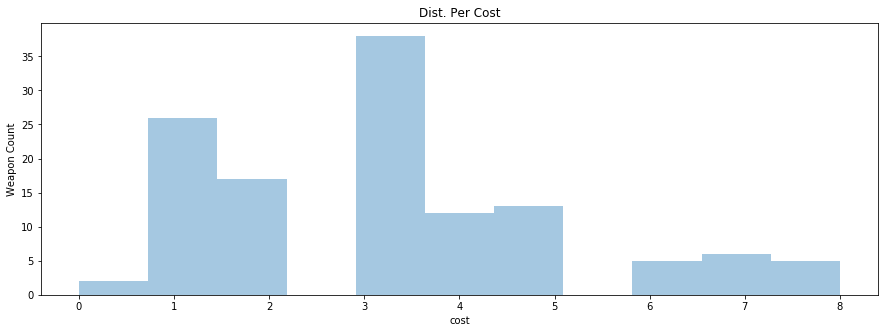

In [36]:
weapons_dataframe = altered_dataframe[altered_dataframe.type == 'Weapon'][['cost']]

fig, axs = plot.subplots(figsize=(15,5), ncols=1, nrows=1)
sns.distplot(weapons_dataframe['cost'], kde=False, bins=11, ax=axs)

axs.set_ylabel('Weapon Count')
axs.set_title('Dist. Per Cost')

plot.show()

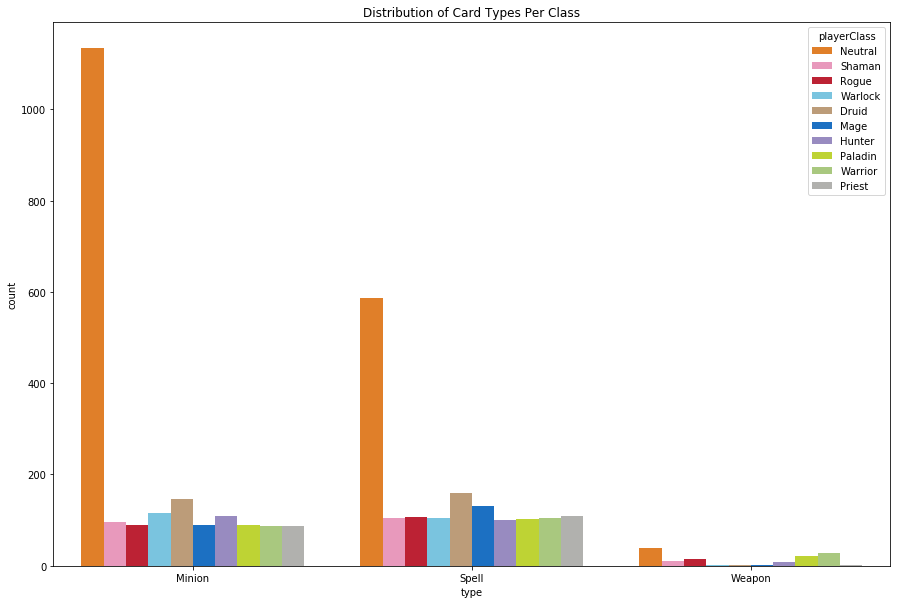

In [37]:
fig, axs = plot.subplots(figsize=(15,10), ncols=1, nrows=1)
cards_dataset = altered_dataframe[['playerClass', 'type']]

axs.set_title('Distribution of Card Types Per Class')
sns.countplot(x='type',data=cards_dataset, hue='playerClass', palette=classes_palette, ax=axs)
plot.show()

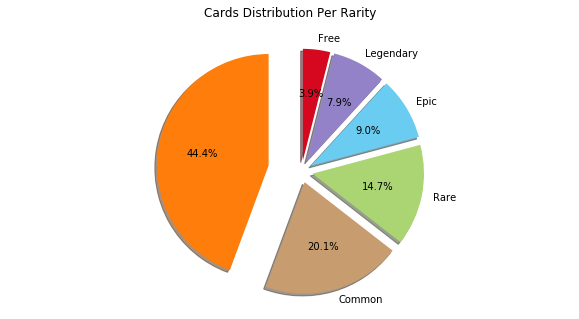

In [38]:
cards_per_class = altered_dataframe['rarity'].value_counts()
classes = cards_per_class.keys()
cards_count = cards_per_class.values
explode = (0.3, 0.1, 0.1, 0.1, 0.1, 0.1)

rarity_colors = ['#FF7D0A', '#C79C6E', '#ABD473', '#69CCF0', '#9482C9', '#D60820']

fig, axes = plot.subplots(nrows=1, ncols=1, figsize=(10,5))

axes.set_title('Cards Distribution Per Rarity', y=1.05)
axes.pie(cards_count, labels=classes, colors=rarity_colors, explode=explode,
        autopct='%1.1f%%', shadow=True, startangle=90)
axes.axis('equal')
plot.show()

### Step 3: Data Visualization (Per Expansion Basis) <a class="anchor" id="data-visualization-per-expansion"></a>

In [39]:
card_sets = altered_dataframe.cardSet.unique()
card_sets

array(['Basic', 'Classic', 'Naxxramas', 'Goblins vs Gnomes',
       'Blackrock Mountain', 'The Grand Tournament',
       'The League of Explorers', 'Whispers of the Old Gods',
       'One Night in Karazhan', 'Mean Streets of Gadgetzan',
       "Journey to Un'Goro", 'Knights of the Frozen Throne',
       'Kobolds & Catacombs', 'The Witchwood', 'The Boomsday Project',
       "Rastakhan's Rumble", 'Rise of Shadows'], dtype=object)

In [40]:
def viewCardDistributionPerExpansion(expansion, dataframe):
    _cards_per_class = dataframe.playerClass.value_counts()
    _classes = _cards_per_class.keys()
    _cards_count = _cards_per_class.values
    _explode = (0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3, 0.3)

    _fig, _axes = plot.subplots(nrows=1, ncols=1, figsize=(10,5))
    _axes.set_title(expansion, y=1.05)
    _axes.pie(_cards_count, labels=_classes, colors=class_colors, explode=_explode, autopct='%1.1f%%', shadow=True, startangle=90)
    _axes.axis('equal')
    
def viewMinionDistributionPerExpansion(expansion, dataframe):
    sns.pairplot(dataframe, hue='type', kind='scatter')
    plot.suptitle(expansion, y=1.05)
    plot.show()
    
def viewSpellDistributionPerExpansion(expansion, dataframe):
    _fig, _axs = plot.subplots(figsize=(15,5), ncols=1, nrows=1)
    sns.distplot(dataframe['cost'], kde=False, bins=11, ax=axs)

    _axs.set_ylabel('Spell Count')
    _axs.set_title('Dist. Per Cost')

    plot.show()
    
def viewWeaponDistributionPerExpansion(expansion, dataframe):
    _fig, _axs = plot.subplots(figsize=(15,5), ncols=1, nrows=1)
    sns.distplot(dataframe['cost'], kde=False, bins=11, ax=axs)

    _axs.set_ylabel('Weapon Count')
    _axs.set_title('Dist. Per Cost')

    plot.show()
    
def viewCardDistributionPerClassPerExpansion(expansion, dataframe):
    _fig, _axs = plot.subplots(figsize=(15,10), ncols=1, nrows=1)

    _axs.set_title(expansion)
    sns.countplot(x='type', data=dataframe, hue='playerClass', palette=classes_palette, ax=_axs)
    plot.show()
    
def viewCardRarityDistributionPerExpansion(expansion, dataframe):
    _cards_per_class = dataframe['rarity'].value_counts()
    _classes = _cards_per_class.keys()
    _cards_count = _cards_per_class.values
    _explode = (0.3, 0.1, 0.1, 0.1, 0.1, 0.1)

    rarity_colors = ['#FF7D0A', '#C79C6E', '#ABD473', '#69CCF0', '#9482C9', '#D60820']

    _fig, _axes = plot.subplots(nrows=1, ncols=1, figsize=(10,5))

    _axes.set_title(expansion, y=1.05)
    _axes.pie(_cards_count, labels=_classes, colors=rarity_colors, explode=_explode[:len(_classes)],
            autopct='%1.1f%%', shadow=True, startangle=90)
    _axes.axis('equal')
    plot.show()

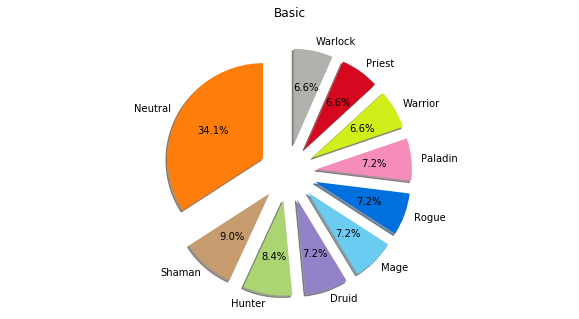

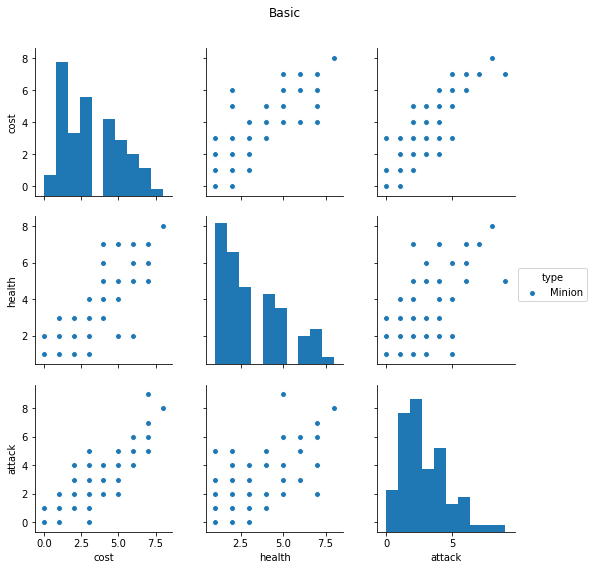

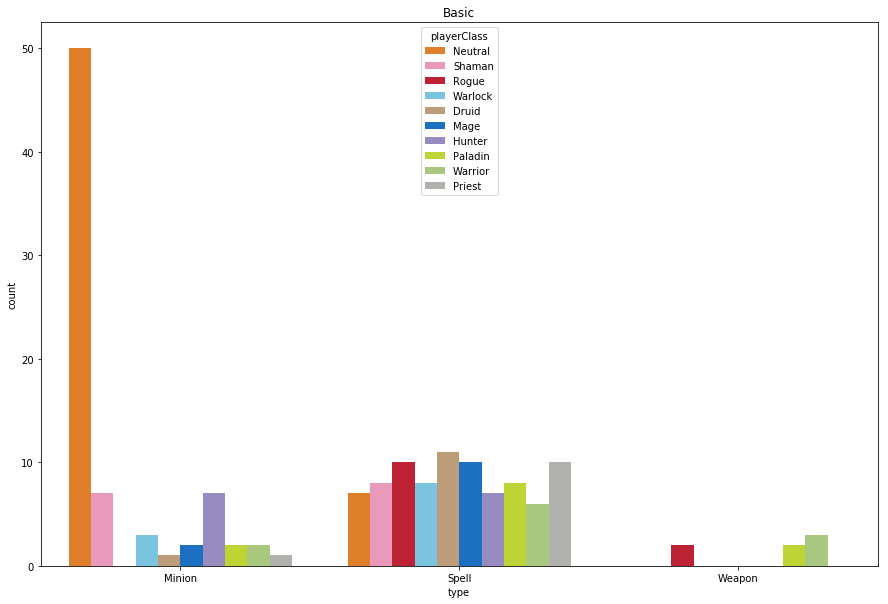

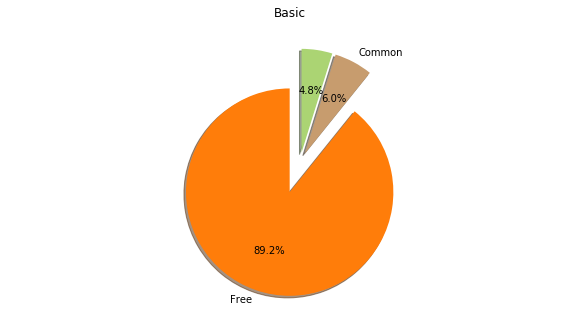

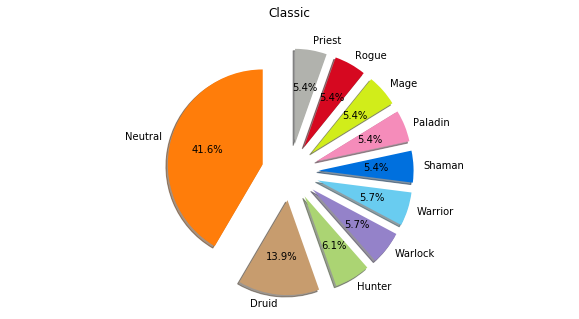

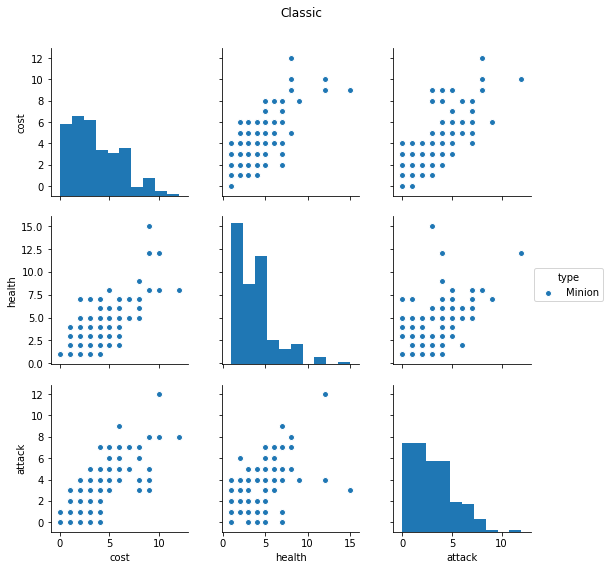

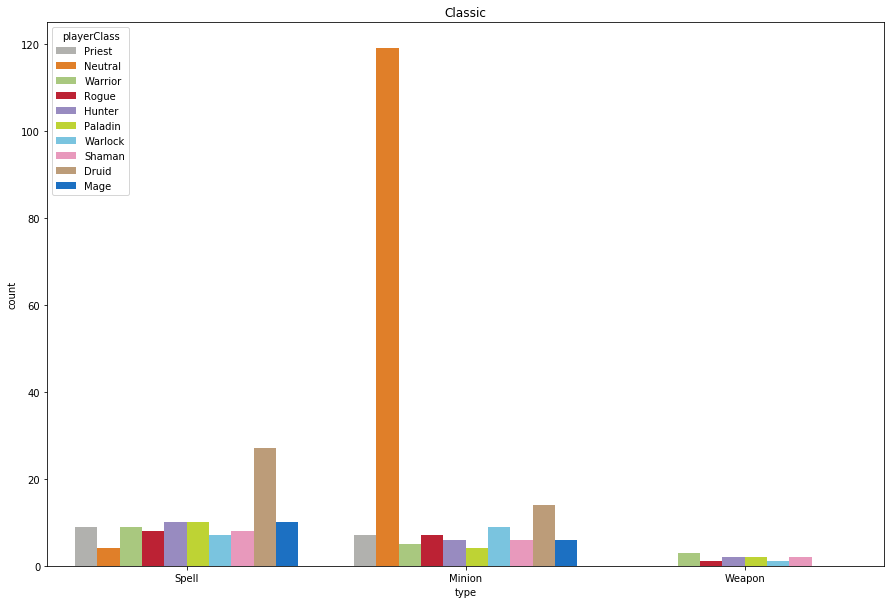

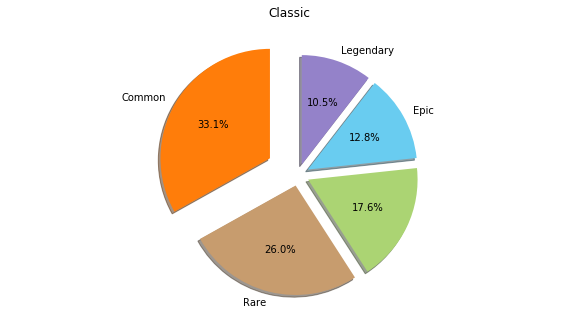

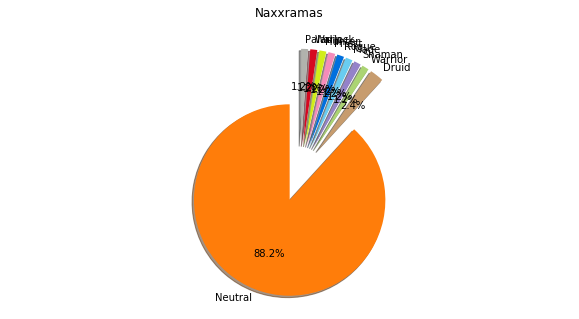

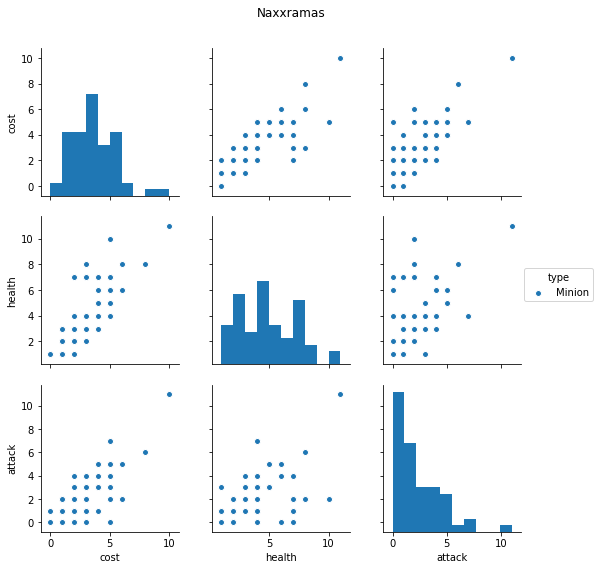

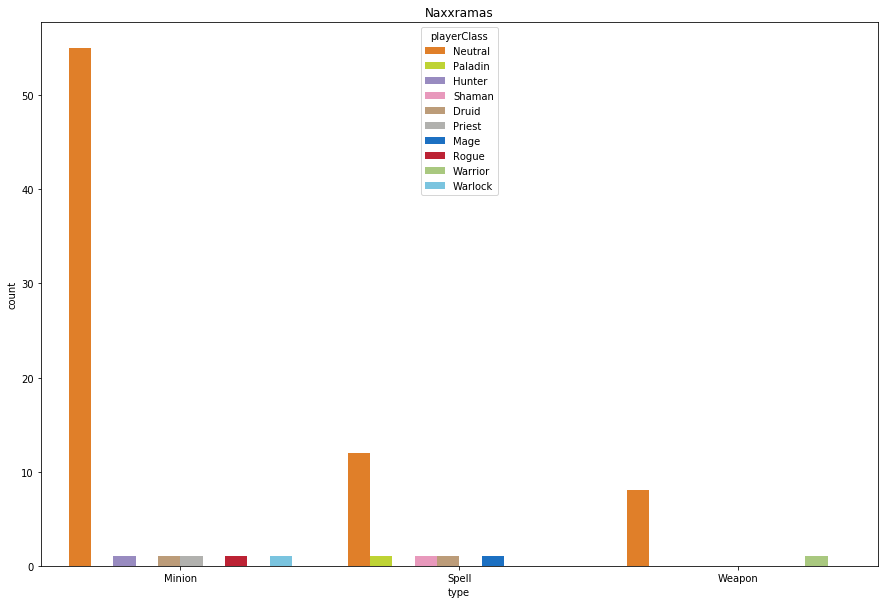

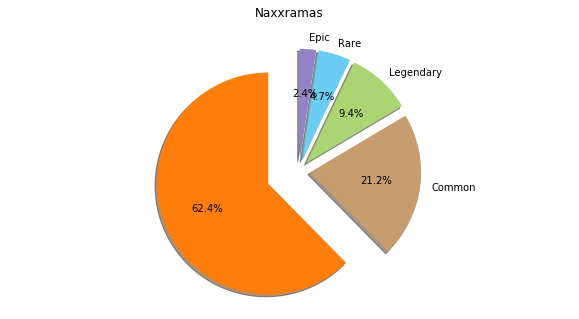

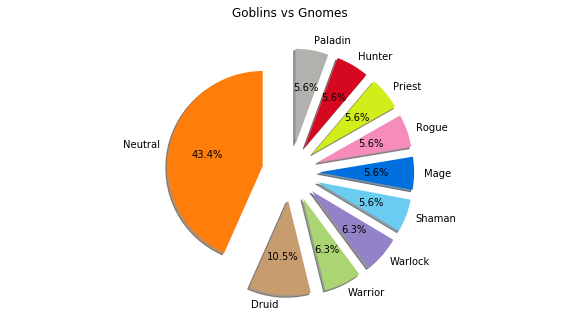

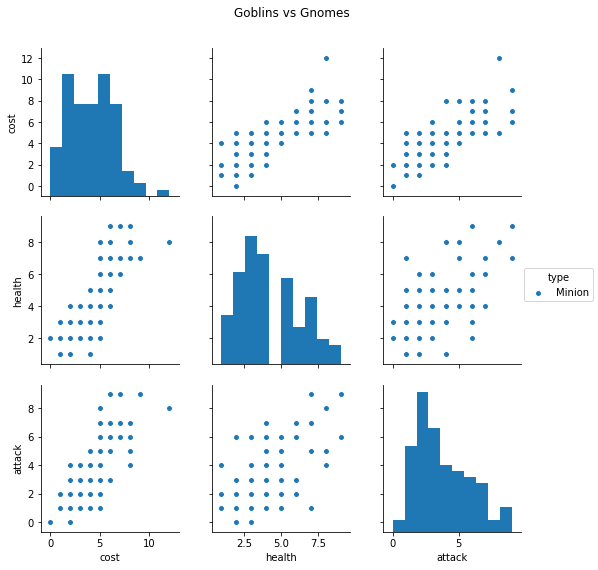

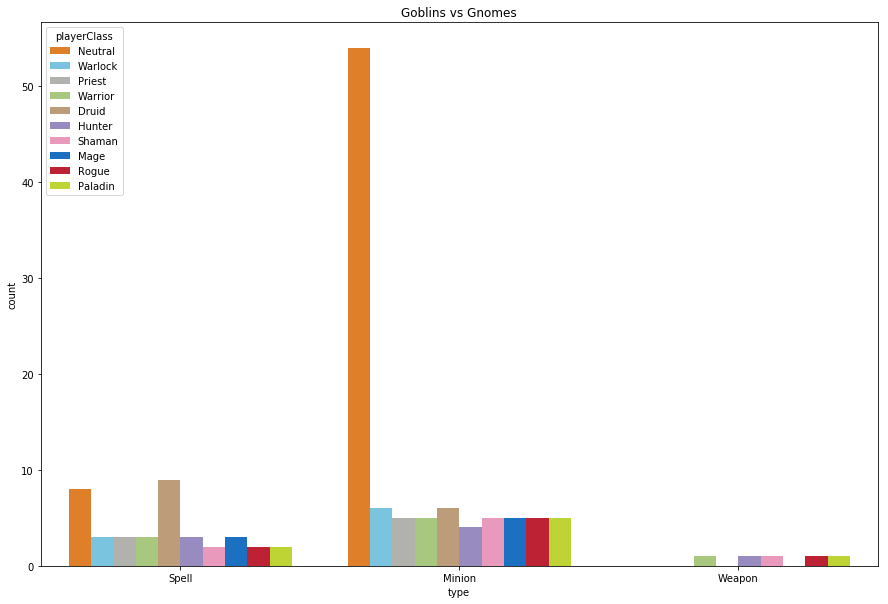

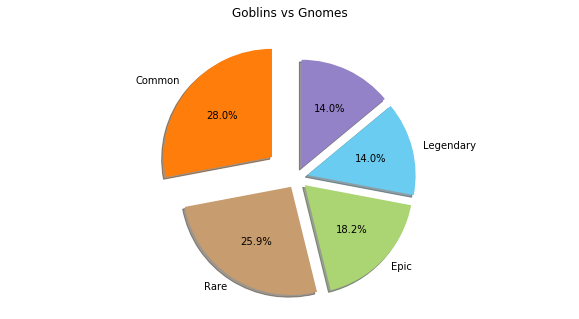

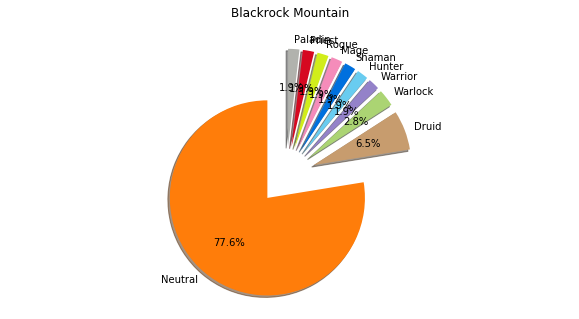

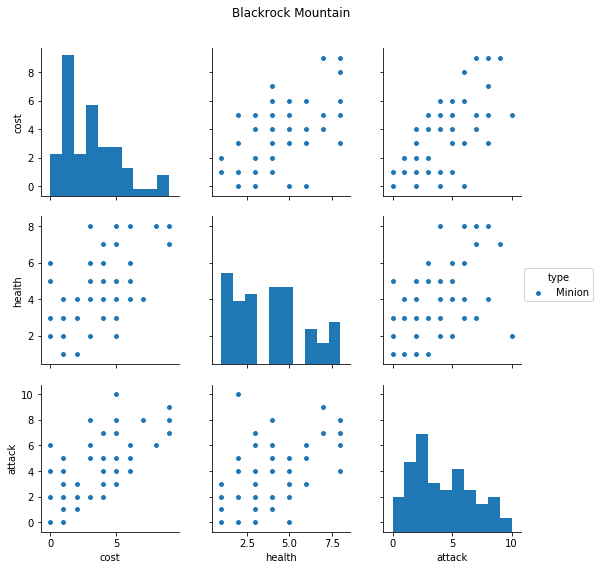

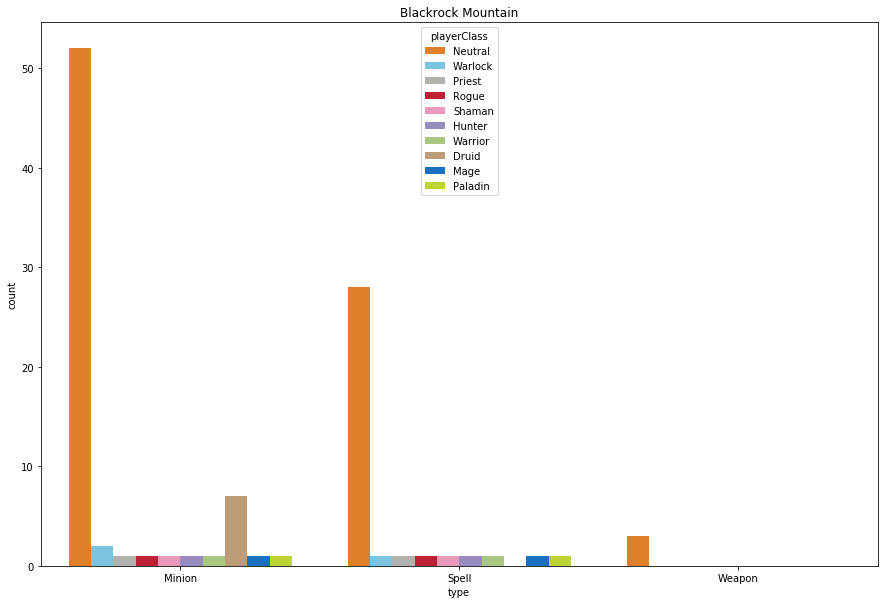

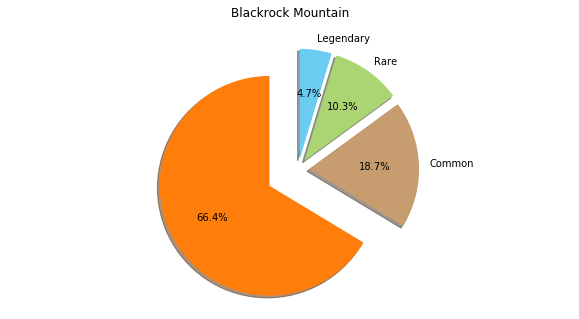

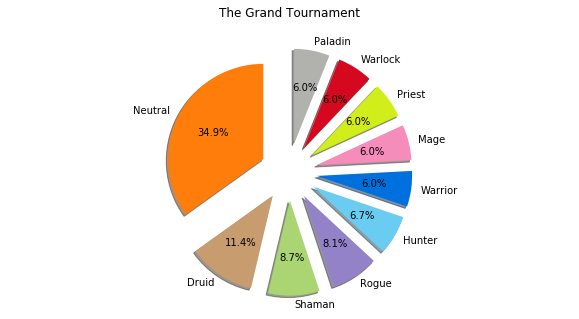

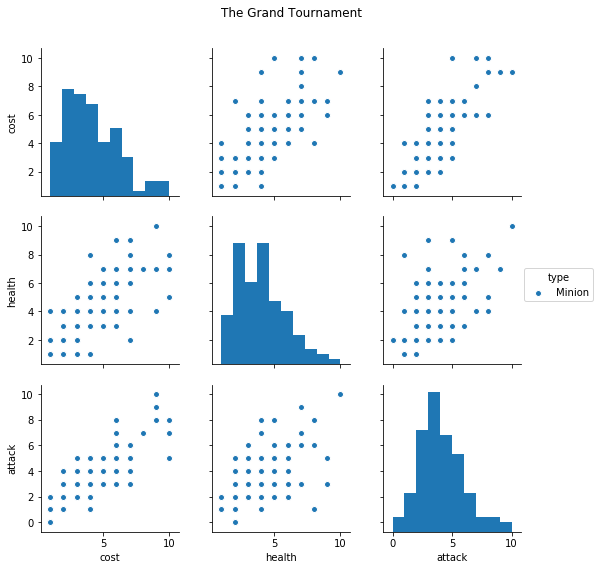

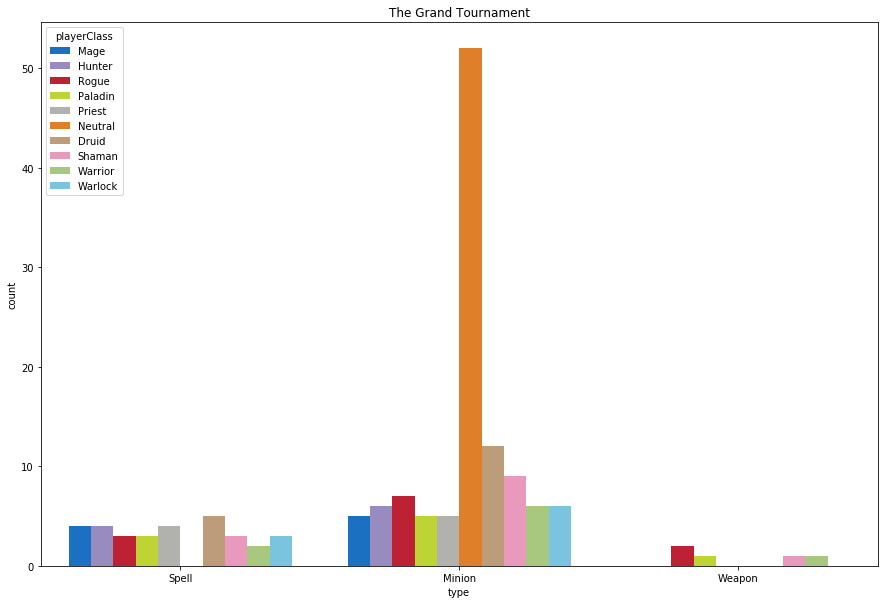

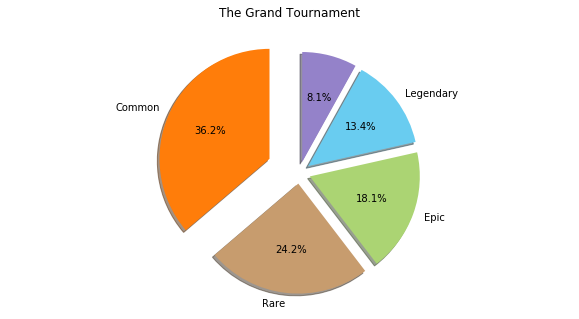

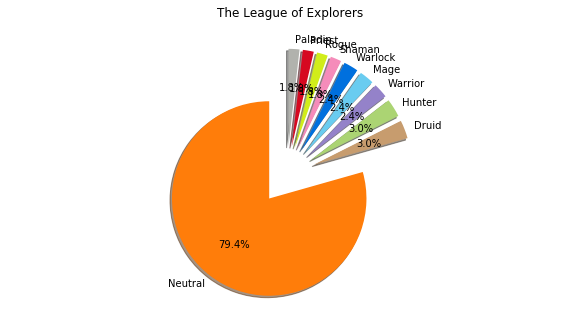

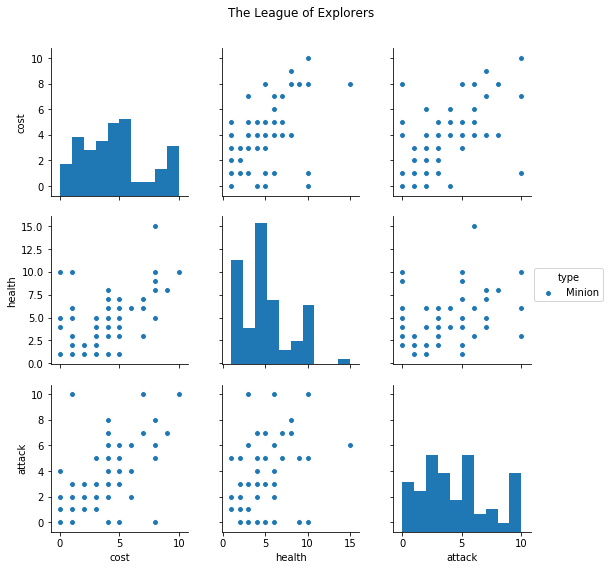

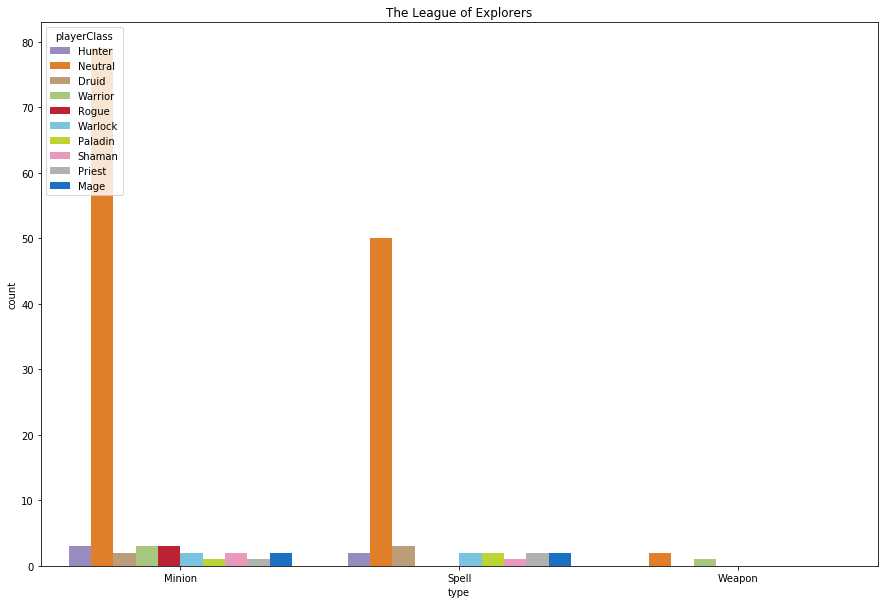

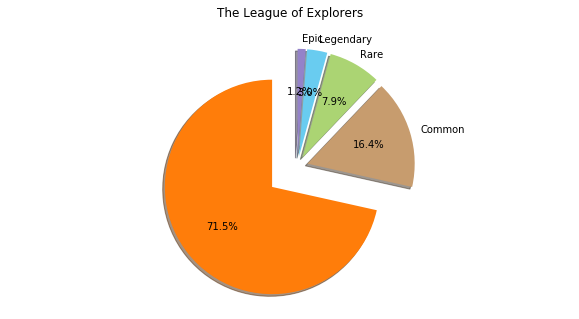

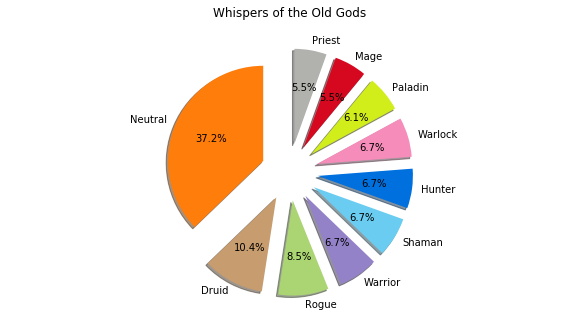

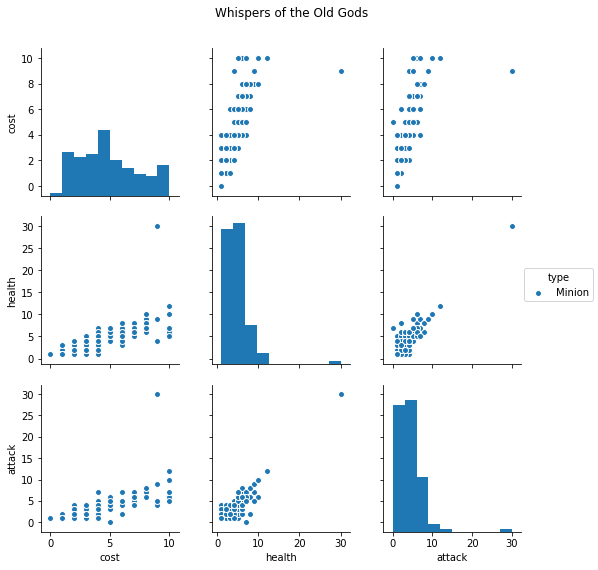

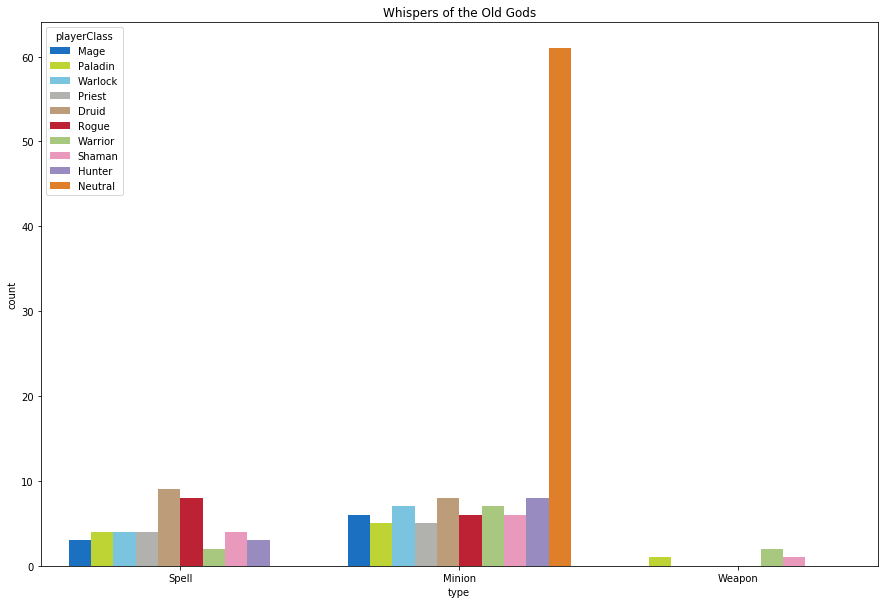

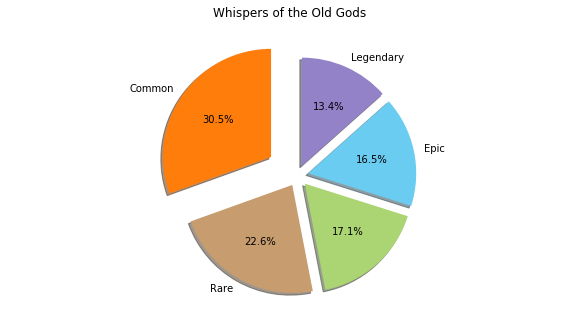

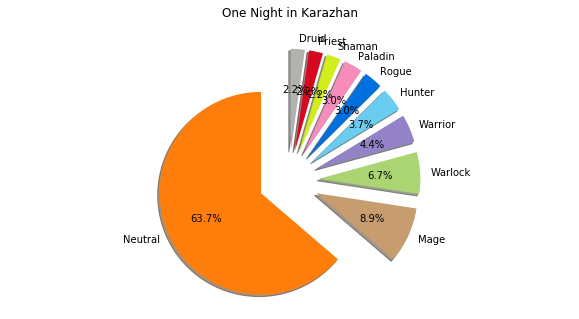

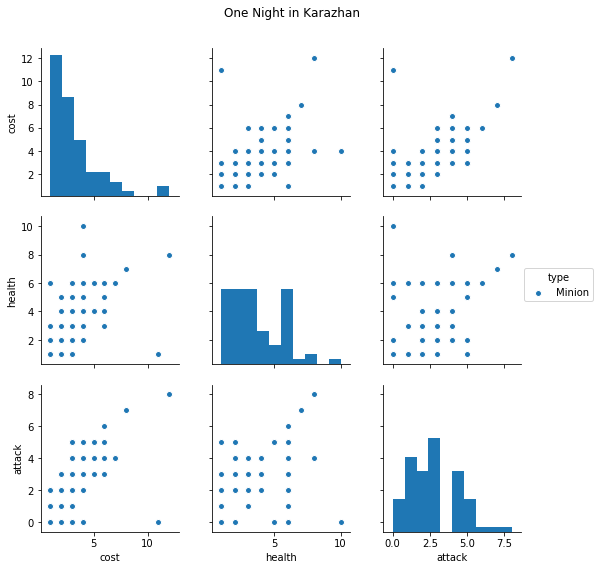

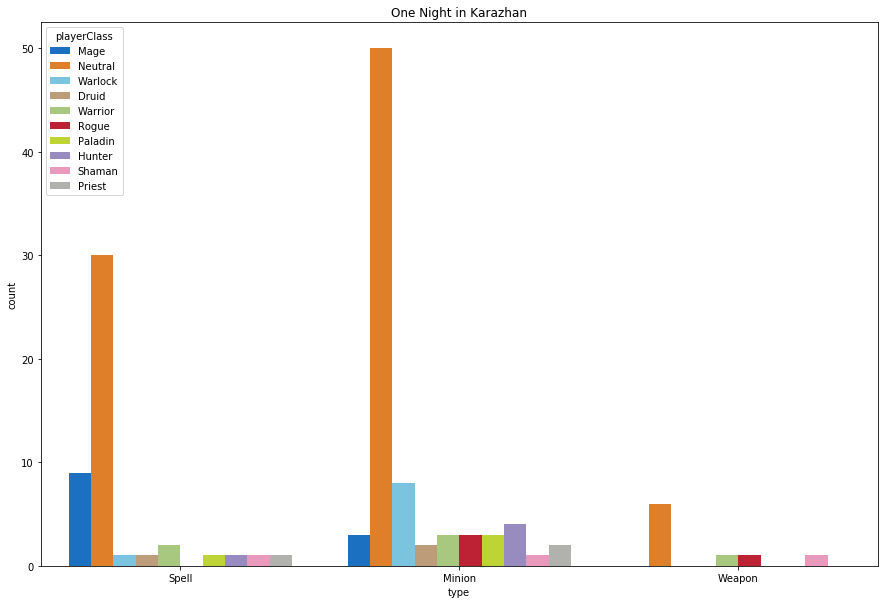

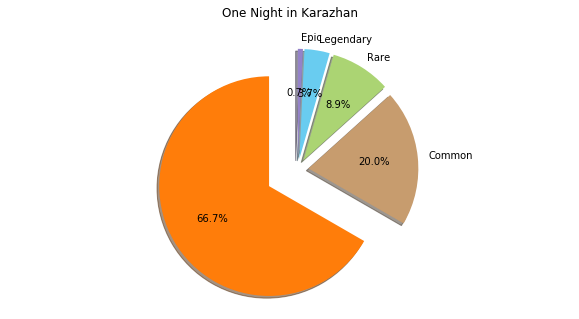

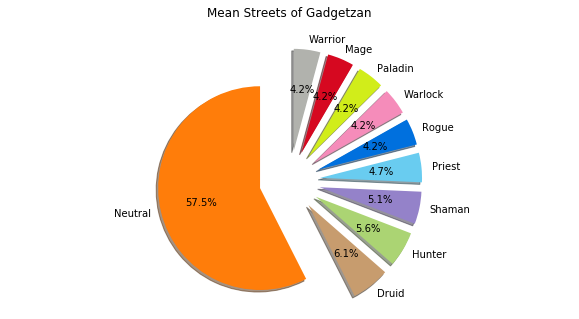

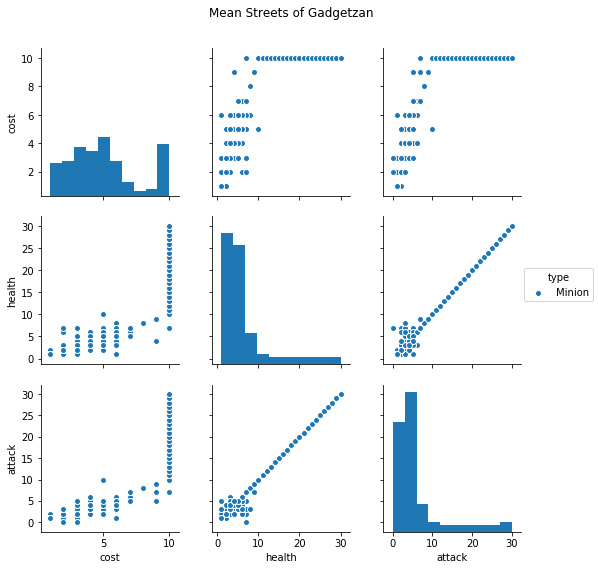

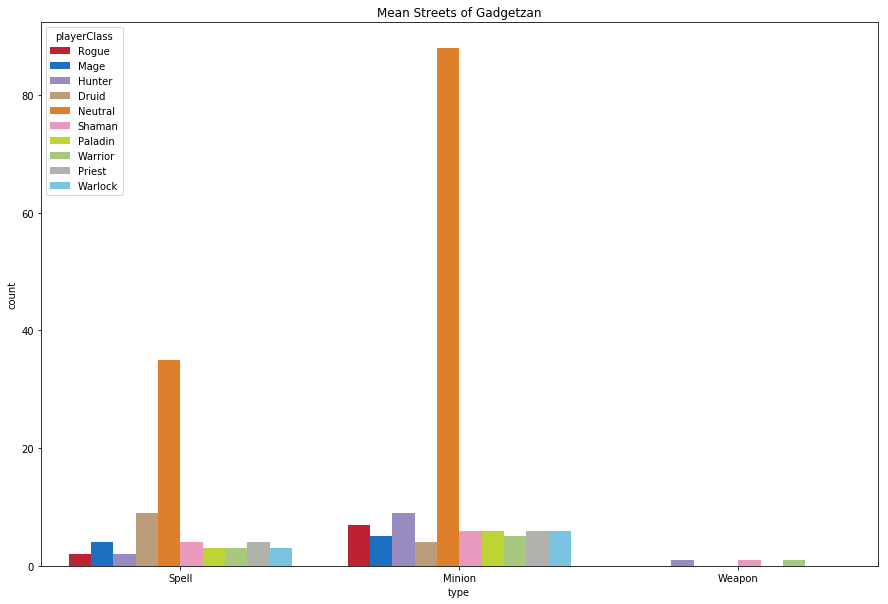

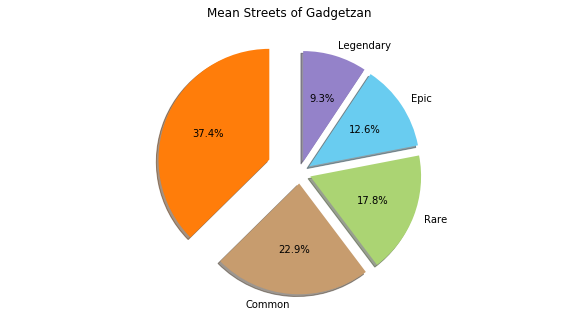

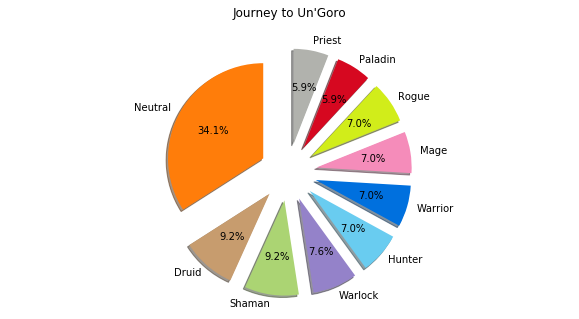

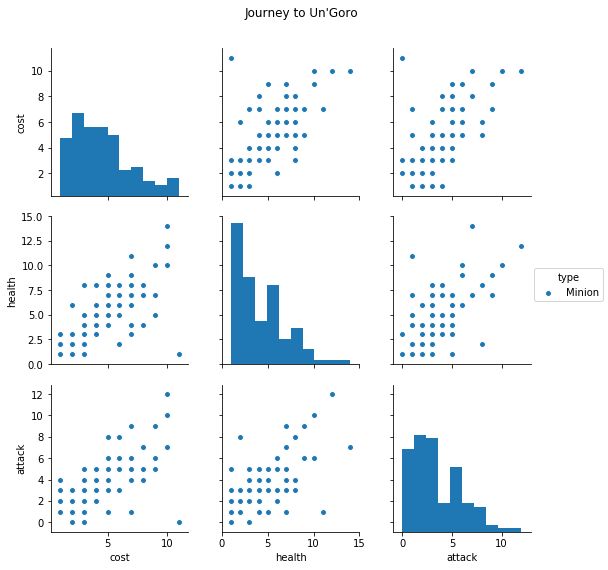

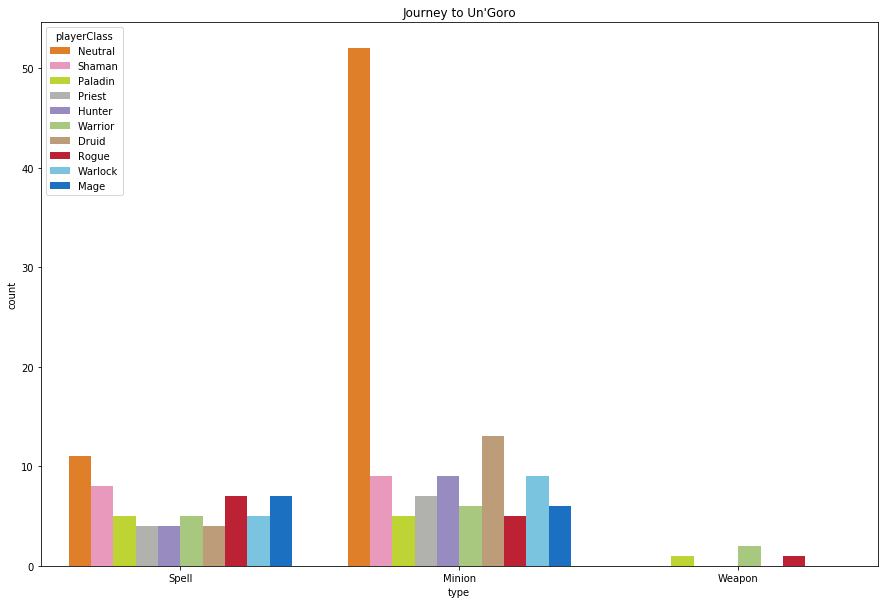

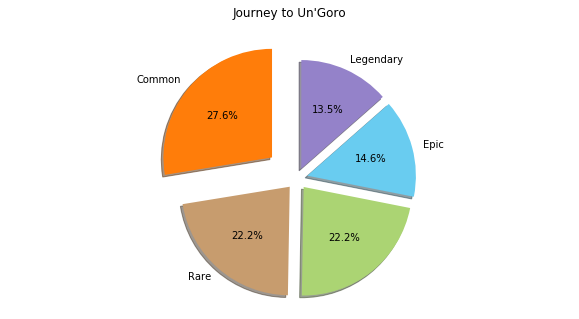

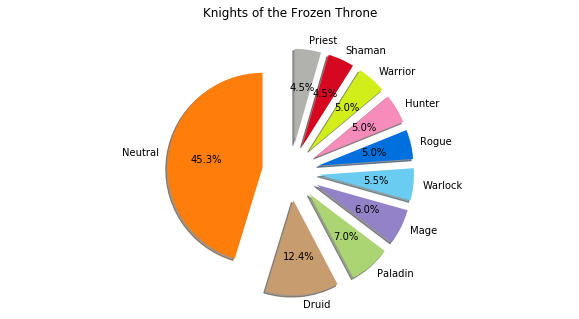

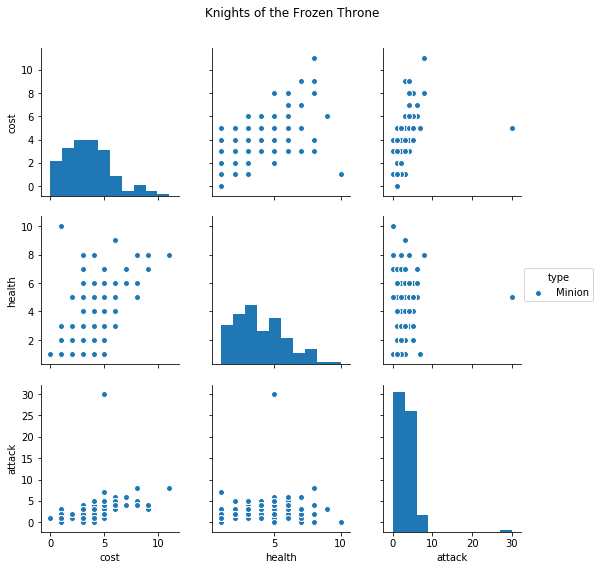

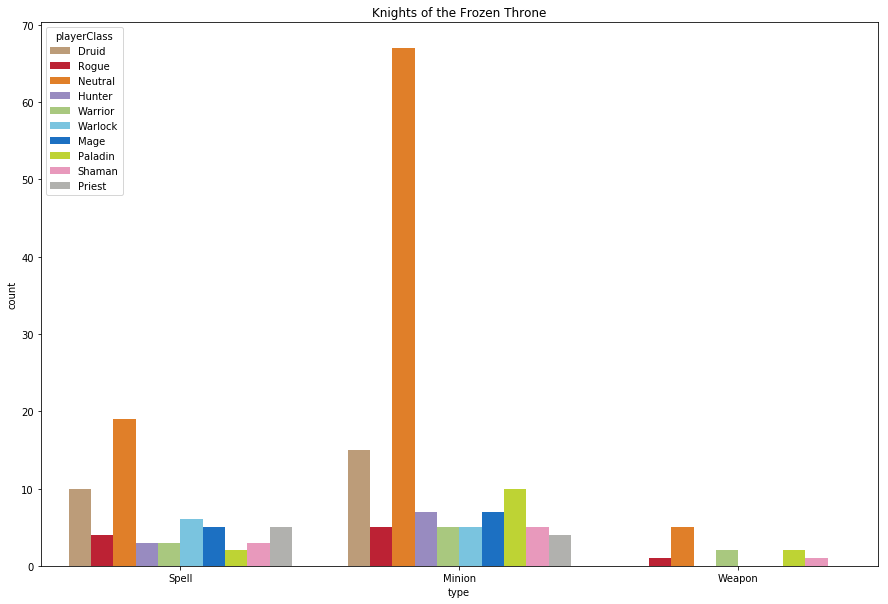

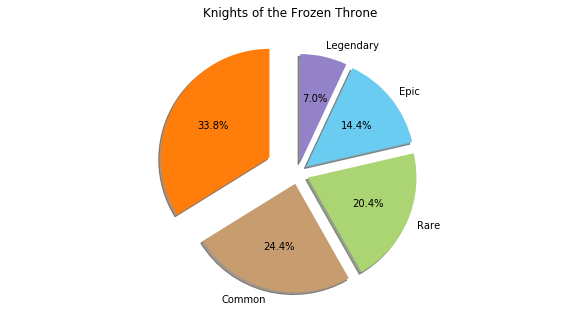

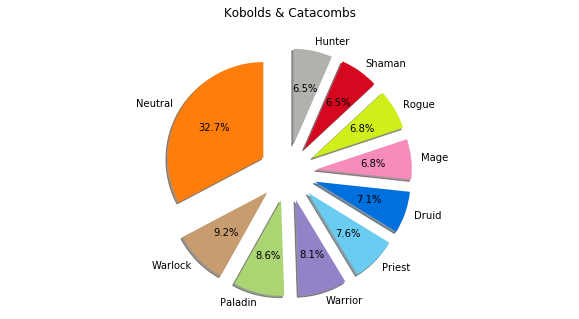

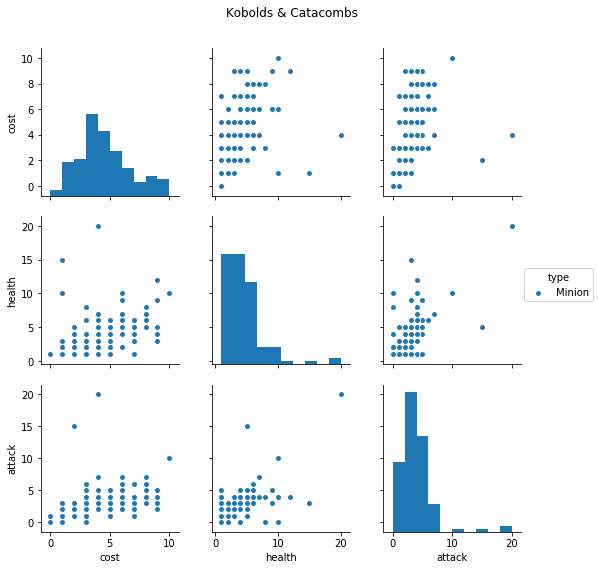

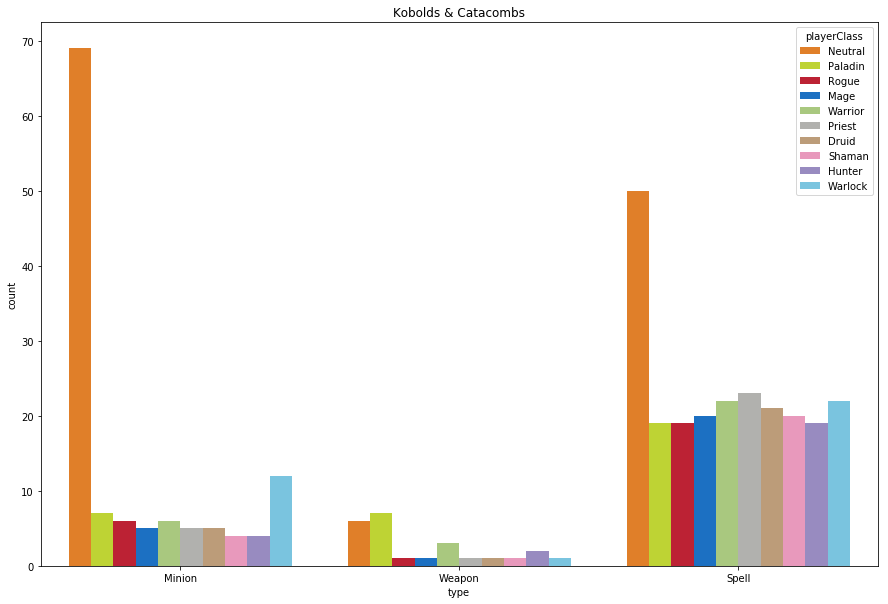

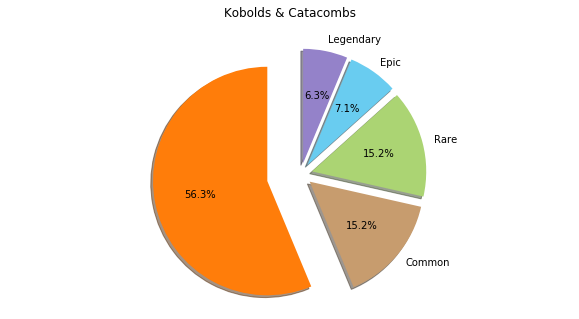

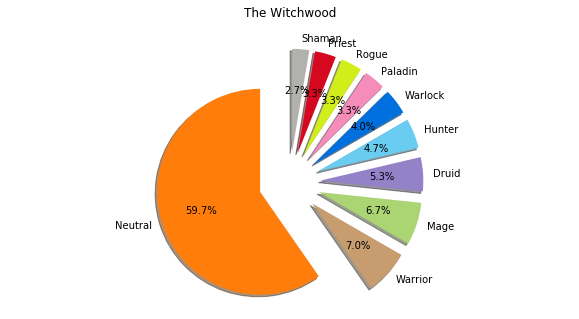

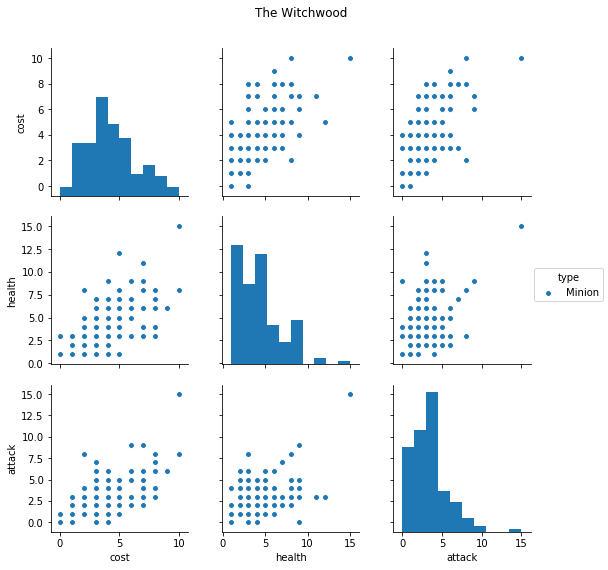

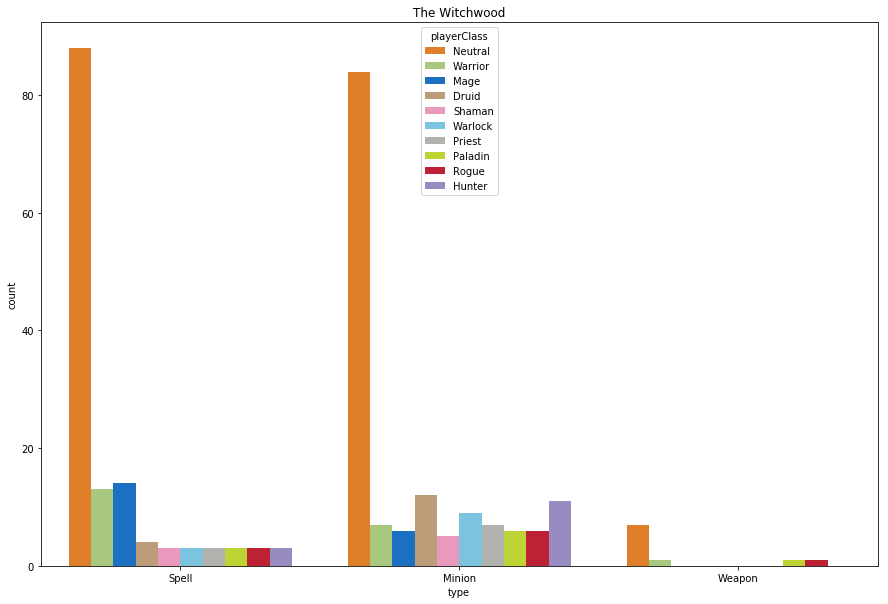

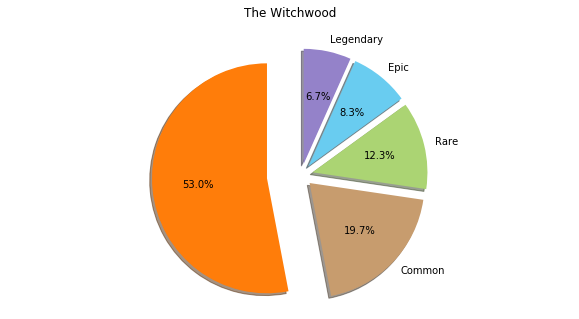

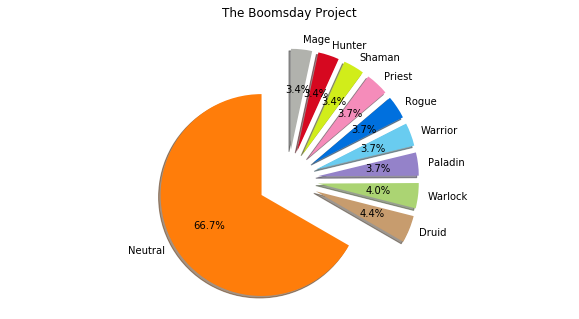

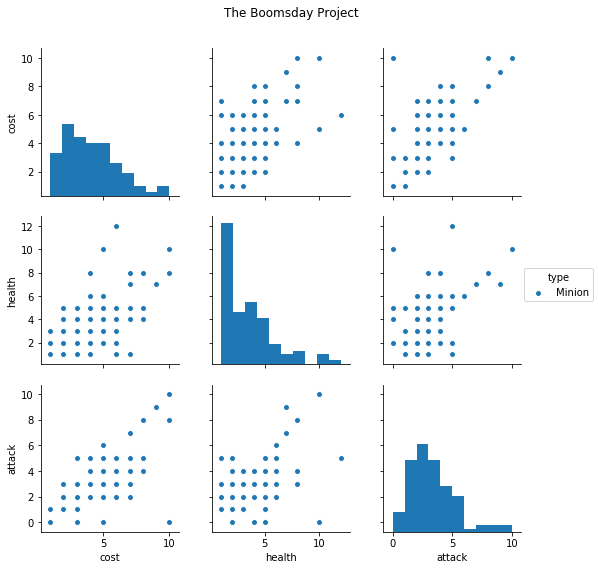

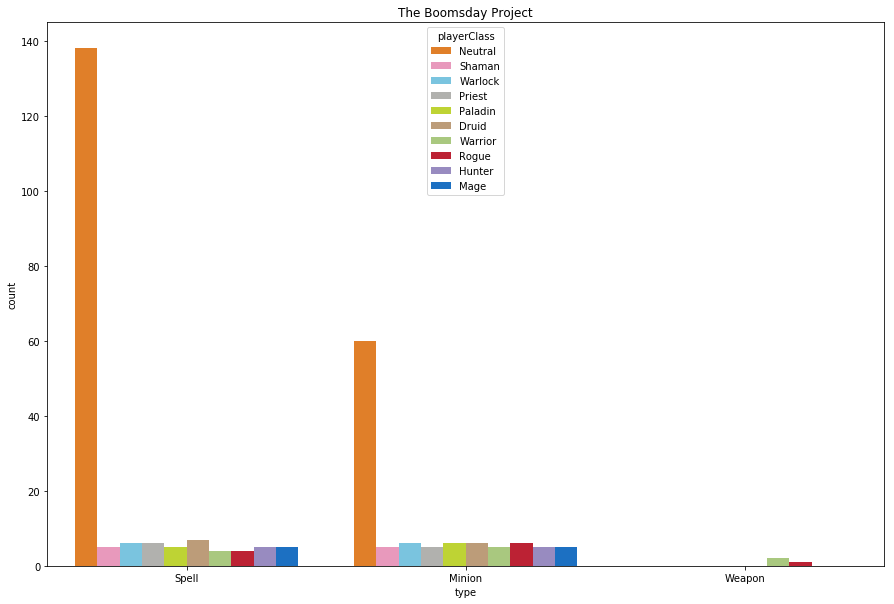

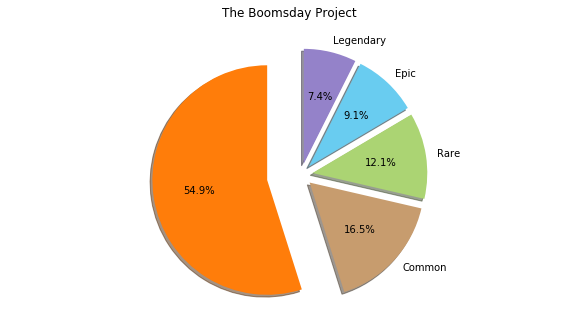

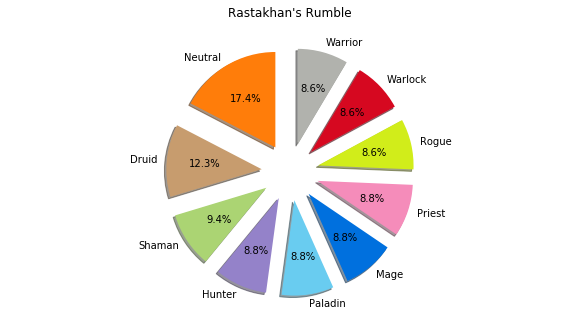

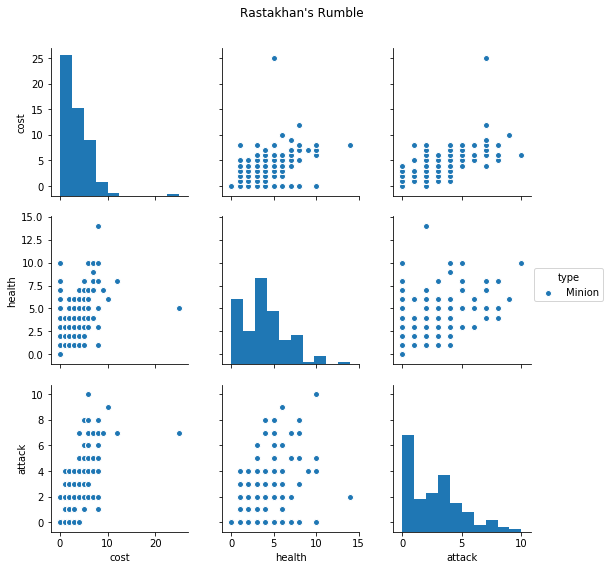

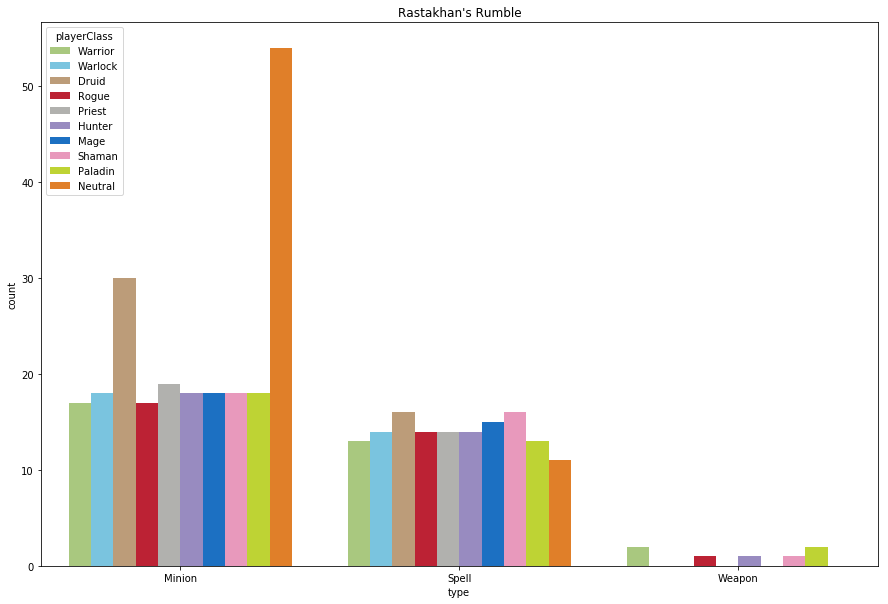

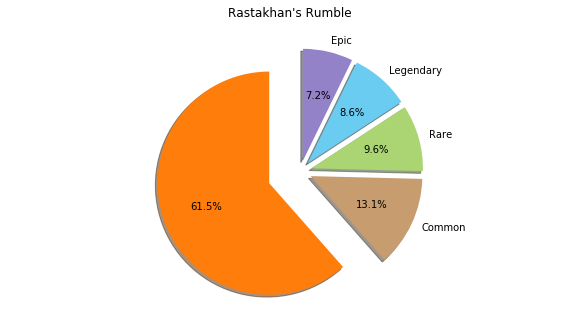

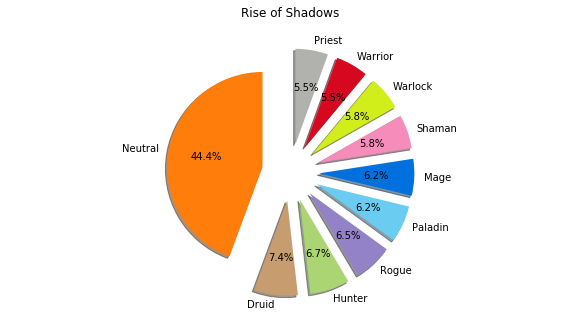

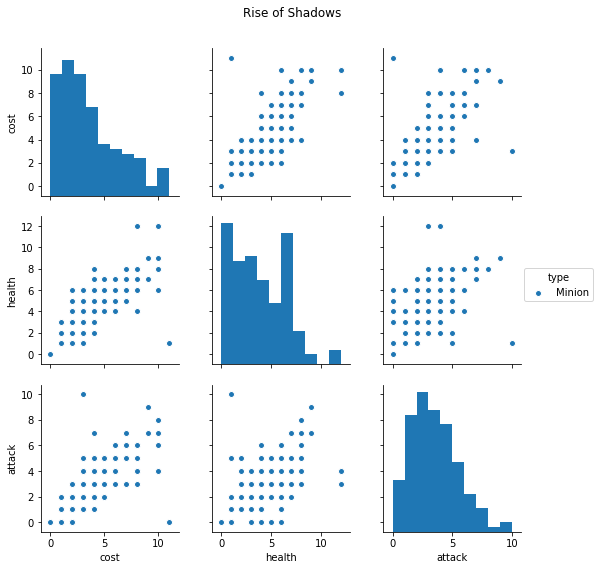

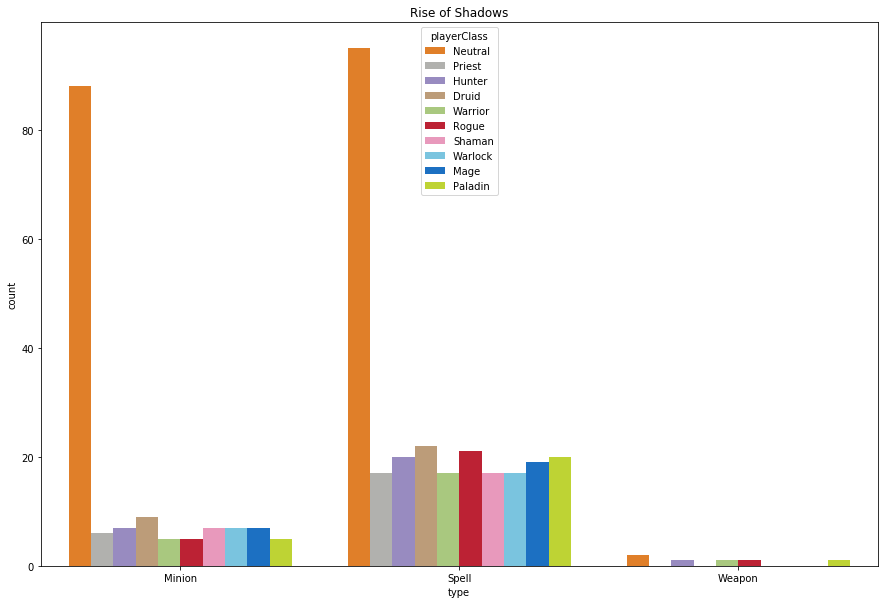

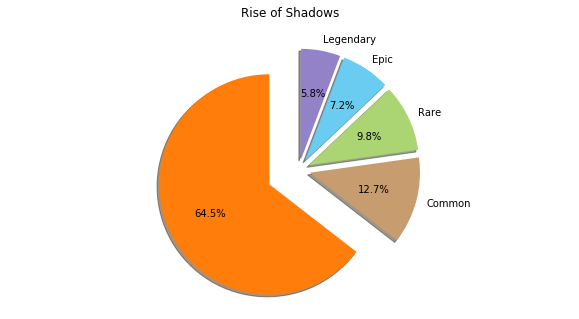

In [41]:
for expansion in card_sets:
    tempSet = altered_dataframe[altered_dataframe.cardSet == expansion]
    viewCardDistributionPerExpansion(expansion, tempSet)
    
    minions_per_expansion = tempSet[tempSet.type == 'Minion'][['cost', 'health', 'attack', 'type']]
    viewMinionDistributionPerExpansion(expansion, minions_per_expansion)
    
    cards_dataset_per_expansion = tempSet[['playerClass', 'type']]
    viewCardDistributionPerClassPerExpansion(expansion, cards_dataset_per_expansion)
    
    viewCardRarityDistributionPerExpansion(expansion, tempSet)

## Part 2: Q-Learning for FrozenLake-v0, OpenAI Gym environment <a class="anchor" id="frozen-lake"></a>

The idea behind this is, just parsing data is not that exciting... aaannnd, I don't have time to make **Self taught Quantum Checkers** the _**thing**_. So I've used existing <a href="https://gym.openai.com/">environment</a> and a <a href="https://gym.openai.com/envs/FrozenLake8x8-v0/">Frozen Lake 8x8</a> in particular.

**Basic Idea**:
The agent controls the movement of a character in a grid world. Some tiles of the grid are walkable, and others lead to the agent falling into the water. Additionally, the movement direction of the agent is uncertain and only partially depends on the chosen direction. The agent is rewarded for finding a walkable path to a goal tile.

_Winter is here. You and your friends were tossing around a frisbee at the park when you made a wild throw that left the frisbee out in the middle of the lake. The water is mostly frozen, but there are a few holes where the ice has melted. If you step into one of those holes, you'll fall into the freezing water. At this time, there's an international frisbee shortage, so it's absolutely imperative that you navigate across the lake and retrieve the disc. However, the ice is slippery, so you won't always move in the direction you intend._

**Grid is Described**:
- S: starting point, safe
- F: frozen surface, safe
- H: hole, fall to your doom
- G: goal, where the frisbee is located

**Example**: <br>
SFFF <br>
FHFH <br>
FFFH <br> 
HFFG <br>

**Glossary**:
- **environment** — It is like an object or interface through which we or our game bot(agent) can interact with the game and get details of current state and etc. There are several different games or environments available. You can find them here. 
- **step** - It’s a function through which we can do an action like what actually we want to do to at the current state/stage of the game.
- **action** - It’s a value or object which we basically want to do at the current state/stage of the game. Like moving right or left or jump or etc.
- **observation (object)** - An environment-specific object representing your observation of the environment. For example, pixel data from a camera, joint angles and joint velocities of a robot, or the board state in a board game.
- **reward (float)** - Amount of reward achieved by the previous action. The scale varies between environments, but the goal is always to increase your total reward.
- **done (boolean)** - whether it’s time to reset the environment again. Most (but not all) tasks are divided up into well-defined episodes, and done being True indicates the episode has terminated. (For example, perhaps the pole tipped too far, or you lost your last life.)
- **info (dictionary)** - diagnostic information useful for debugging. It can sometimes be useful for learning (for example, it might contain the raw probabilities behind the environment’s last state change). However, official evaluations of your agent are not allowed to use this for learning.

In [1]:
'''
    If following import fails, just install gym from anaconda console, using:
        pip install gym
'''
import gym
import numpy as np
import time, pickle, os

In [2]:
# Global constants
epsilon = 0.9
total_epoches = 10000
max_steps = 1000

lr_rate = 0.81
gamma = 0.96

### Q-Learning Approach <a class="anchor" id="q-learn"></a>

Before moving to DNN implementation, I've decided to use <a href="https://en.wikipedia.org/wiki/Q-learning">Q-learning</a> algorithm.
The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances.

#### OpenAI Gym Stochastic FrozenLake Approach <a class="anchor" id="stochastic-field"></a>

In this context, **stochastic** means that upon action selection there still is 1/3 of a chance to end up on different tile, due to environment. You see - ice is slippery.

In [3]:
# Load OpenAI gym environment
env_stochastic = gym.make('FrozenLake-v0')

# Define our Q-Learn matrix
Q_stochastic = np.zeros((env_stochastic.observation_space.n, env_stochastic.action_space.n))
file_Q_stochastic = "frozenLake_stochastic_qTable.pkl"

# Preview board
env_stochastic.render()


SFFF
FHFH
FFFH
HFFG


In [45]:
# Defines all possible actions our agent can take. In our case it's a space of 4 actions: Left, Right, Up, Down and they are coded as [0,1,2,3].
display(env_stochastic.action_space)

# Defines observation space for our agent. In our case it's a descrete 4x4 board.
display(env_stochastic.observation_space)

# Defines reward range. In our case o if failed and 1 if succeded
display(env_stochastic.reward_range)

Discrete(4)

Discrete(16)

(0, 1)

In [46]:
# Used to dump Q-Matrices to files
def SaveQTableToFile(Q, name):
    with open(name, 'wb') as f:
        pickle.dump(Q, f)

In [47]:
# "Epsilon Greedy" action selection
def choose_action(state, environment, Q):
    action=0
    if np.random.uniform(0, 1) < epsilon:
        action = environment.action_space.sample()
    else:
        action = np.argmax(Q[state, :])
    return action

# Learning function
def learn(state, state2, reward, action, Q):
    predict = Q[state, action]
    target = reward + gamma * np.max(Q[state2, :])
    Q[state, action] = Q[state, action] + lr_rate * (target - predict)

# Train function
def initQLearn(epoches, environment, Q, showOutput=False):
    for episode in range(epoches):
        state = environment.reset()
        t = 0
        while t < max_steps:
            if showOutput == True:
                environment.render()

            action = choose_action(state, environment, Q)  
            state2, reward, done, info = environment.step(action)
            if showOutput == True:
                print("Reward:", reward)
                print("Info:", info)
            
            learn(state, state2, reward, action, Q)
            state = state2
            t += 1
       
            if done == True and reward == 1:
                print('Episode', episode, 'was successful. Agent has reached the Exit.')
                break

            if showOutput == True:
                time.sleep(0.1)
    
    print('Our Q is equal:\n', Q)

In [48]:
# Train Q-Learn model on stochastic environment
initQLearn(total_epoches, env_stochastic, Q_stochastic, False)

Episode 72 was successful. Agent has reached the Exit.
Episode 105 was successful. Agent has reached the Exit.
Episode 118 was successful. Agent has reached the Exit.
Episode 148 was successful. Agent has reached the Exit.
Episode 191 was successful. Agent has reached the Exit.
Episode 224 was successful. Agent has reached the Exit.
Episode 333 was successful. Agent has reached the Exit.
Episode 355 was successful. Agent has reached the Exit.
Episode 371 was successful. Agent has reached the Exit.
Episode 479 was successful. Agent has reached the Exit.
Episode 673 was successful. Agent has reached the Exit.
Episode 752 was successful. Agent has reached the Exit.
Episode 867 was successful. Agent has reached the Exit.
Episode 869 was successful. Agent has reached the Exit.
Episode 898 was successful. Agent has reached the Exit.
Episode 1058 was successful. Agent has reached the Exit.
Episode 1115 was successful. Agent has reached the Exit.
Episode 1145 was successful. Agent has reached 

In [49]:
# Save our Q-Matrix to file
SaveQTableToFile(Q_stochastic, file_Q_stochastic)

Below function does not depend on any additional learning, so it can be freely changed.

In [2]:
# This function will select Move (Action) based on State and all previous Experience saved in model.
def choose_QModel_action(state, verbose, Q):
    action = np.argmax(Q[state, :])
    if verbose == True:
        print (action)
    return action

def initPlayByQModel(episodes_count, environment, file_QTable, showOutput=True, verbose=False):
    with open(file_QTable, 'rb') as f:
        _Q = pickle.load(f)

    for episode in range(episodes_count):
        state = environment.reset()
        
        print("*** Starting Episode: ", episode)
        t = 0
        
        while t < max_steps:
            if showOutput == True:
                environment.render()

            action = choose_QModel_action(state, verbose, _Q)
            state2, reward, done, info = environment.step(action)
            
            if verbose == True:
                print("Reward:", reward)
                print("Info:", info)
                print("State2:", state2)
                
            state = state2
            t += 1

            if done == True and reward == 1:
                print('Success: Agent passed the Lake!')
                break
            
            if done == True and reward == 0:
                print('Agent died in vain!')
                break
                
        os.system('clear')

In [20]:
# Due to environment running it few times, may and will produce different outcomes.
initPlayByQModel(10, env_stochastic, file_Q_stochastic, False, False)

*** Starting Episode:  0
Success: Agent passed the Lake!
*** Starting Episode:  1
Success: Agent passed the Lake!
*** Starting Episode:  2
Agent died in vain!
*** Starting Episode:  3
Agent died in vain!
*** Starting Episode:  4
Success: Agent passed the Lake!
*** Starting Episode:  5
Agent died in vain!
*** Starting Episode:  6
Agent died in vain!
*** Starting Episode:  7
Agent died in vain!
*** Starting Episode:  8
Agent died in vain!
*** Starting Episode:  9
Agent died in vain!


#### Personal Deterministic FrozenLake Approach <a class="anchor" id="deterministic-field"></a>

So, as you can see stochastic environment ain't that good for Q-Learning (Let's run few more times here, just to show how bad it is). Let's make environment **deterministic**!
For any references about arguments or environment we can look directly in OpenAI FrozenLake <a href="https://github.com/openai/gym/blob/master/gym/envs/toy_text/frozen_lake.py">implementation</a>.

In [4]:
# First, we need to register our new environment we going to work with
from gym.envs.registration import register

register(id='Deterministic-FrozenLake4x4-v0',
    entry_point='gym.envs.toy_text.frozen_lake:FrozenLakeEnv',
    kwargs={'map_name': '4x4', 'is_slippery': False}
)

In [5]:
# Create new environment instance to work with
env_deterministic = gym.make('Deterministic-FrozenLake4x4-v0')

# Define our Q-Learn matrix
Q_deterministic = np.zeros((env_deterministic.observation_space.n, env_deterministic.action_space.n))
file_Q_deterministic = "frozenLake_deterministic_qTable.pkl"

# Preview board
env_deterministic.render()


SFFF
FHFH
FFFH
HFFG


In [57]:
# Same learning function but for different environment
initQLearn(total_epoches, env_deterministic, Q_deterministic, False)

Episode 19 was successful. Agent has reached the Exit.
Episode 39 was successful. Agent has reached the Exit.
Episode 52 was successful. Agent has reached the Exit.
Episode 66 was successful. Agent has reached the Exit.
Episode 98 was successful. Agent has reached the Exit.
Episode 124 was successful. Agent has reached the Exit.
Episode 199 was successful. Agent has reached the Exit.
Episode 263 was successful. Agent has reached the Exit.
Episode 295 was successful. Agent has reached the Exit.
Episode 331 was successful. Agent has reached the Exit.
Episode 394 was successful. Agent has reached the Exit.
Episode 406 was successful. Agent has reached the Exit.
Episode 412 was successful. Agent has reached the Exit.
Episode 434 was successful. Agent has reached the Exit.
Episode 498 was successful. Agent has reached the Exit.
Episode 500 was successful. Agent has reached the Exit.
Episode 513 was successful. Agent has reached the Exit.
Episode 519 was successful. Agent has reached the Exi

In [58]:
# Save our Q-Matrix to file
SaveQTableToFile(Q_deterministic, file_Q_deterministic)

In [59]:
initPlayByQModel(10, env_deterministic, file_Q_deterministic, False, False)

*** Starting Episode:  0
Success: Agent passed the Lake!
*** Starting Episode:  1
Success: Agent passed the Lake!
*** Starting Episode:  2
Success: Agent passed the Lake!
*** Starting Episode:  3
Success: Agent passed the Lake!
*** Starting Episode:  4
Success: Agent passed the Lake!
*** Starting Episode:  5
Success: Agent passed the Lake!
*** Starting Episode:  6
Success: Agent passed the Lake!
*** Starting Episode:  7
Success: Agent passed the Lake!
*** Starting Episode:  8
Success: Agent passed the Lake!
*** Starting Episode:  9
Success: Agent passed the Lake!


Wow. Environment definitely takes huge place in results.
Let's check differences in learned Q-Matrices:

In [60]:
print("Stochastic:\n\n", Q_stochastic, "\n\n\nDeterministic:\n\n", Q_deterministic)

Stochastic:

 [[0.63155759 0.7260818  0.63098495 0.64096586]
 [0.08923413 0.59320009 0.4857933  0.5864178 ]
 [0.58253307 0.54801955 0.74002867 0.5670273 ]
 [0.09847175 0.43629738 0.52282304 0.5225726 ]
 [0.69112814 0.72705092 0.76905186 0.12600166]
 [0.         0.         0.         0.        ]
 [0.59500203 0.00506861 0.15284422 0.46626663]
 [0.         0.         0.         0.        ]
 [0.73769729 0.12177414 0.02240348 0.75699989]
 [0.02665465 0.75511081 0.84217728 0.79496329]
 [0.88576406 0.8295706  0.79526765 0.79497617]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.15828885 0.02537745 0.92143326 0.16265478]
 [0.83612259 0.99437935 0.90915363 0.94866158]
 [0.         0.         0.         0.        ]] 


Deterministic:

 [[0.78275779 0.8153727  0.8153727  0.78275779]
 [0.78275779 0.         0.84934656 0.8153727 ]
 [0.8153727  0.884736   0.8153727  0.84934656]
 [0.84934656 0.         0.8153727  0.8153727 ]
 [0.8153727  0.84934656 0

#### Play against environment <a class="anchor" id="pve"></a>

Let's adapt environment to be human agent friendly

In [61]:
def initPlayVsEnv(environment, showOutput=True):
    state = environment.reset()
    
    while True:
        if showOutput == True:
            environment.render()

        action = input('Your action? 0 -> Left, 1 -> Down, 2 -> Right, 3 -> Up')
        action = int(action)

        if action >= 4:
            print ('No such input! Try once more (0 to 3)')
            break

        state2, reward, done, info = environment.step(action)
        state = state2
    
        if done == True and reward == 1:
            print('Success: You have passed the lake!')
            break
        
        if done == True and reward == 0:
            print('Bottom of the Lake is Dark and Full of Terrors!')
        break

In [62]:
initPlayVsEnv(env_stochastic, True)


SFFF
FHFH
FFFH
HFFG


Your action? 0 -> Left, 1 -> Down, 2 -> Right, 3 -> Up 0


For some reason it halts :(

### DNN Approach <a class="anchor" id="dnn"></a>

I had no time :'(